<a href="https://colab.research.google.com/github/nkhar21/ML_4/blob/main/FER_CNN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.1 Imports

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nkhar21","key":"5be6dca82ee543f5a1e380f0fccfe96d"}'}

In [ ]:
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 83% 238M/285M [00:00<00:00, 483MB/s]
100% 285M/285M [00:00<00:00, 510MB/s]


In [ ]:
!unzip challenges-in-representation-learning-facial-expression-recognition-challenge.zip

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd

example_submission_df = pd.read_csv('example_submission.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
face_data_df = pd.read_csv('icml_face_data.csv')

# 0.2 Preprocess data

In [ ]:
import numpy as np

# Convert pixel strings to numpy arrays
def process_pixels(pixels_str):
    return np.array(pixels_str.split(), dtype='float32')

# For training
train_df['pixels'] = train_df['pixels'].apply(process_pixels)
x_train = np.stack(train_df['pixels'].values)
y_train = train_df['emotion'].values

# For testing
test_df['pixels'] = test_df['pixels'].apply(process_pixels)
x_test = np.stack(test_df['pixels'].values)

# Normalize and reshape
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)

x_test.shape, x_train.shape, y_train.shape

((7178, 48, 48, 1), (28709, 48, 48, 1), (28709,))

In [ ]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets (e.g. 80% train, 20% val)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

x_train.shape, x_test.shape, y_train.shape, x_val.shape, y_val.shape

((22967, 48, 48, 1), (7178, 48, 48, 1), (22967,), (5742, 48, 48, 1), (5742,))

# 0.3 wandb

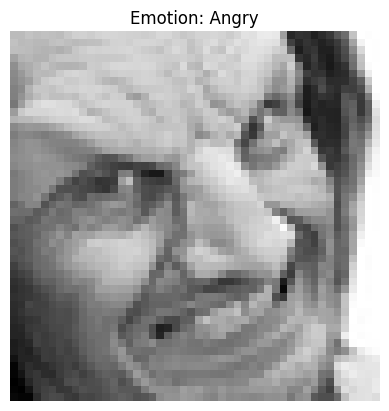

In [ ]:
import matplotlib.pyplot as plt
idx = 10


emotion_dict = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}

plt.imshow(x_train[idx].squeeze(), cmap='gray')
plt.title(f'Emotion: {emotion_dict[y_train[idx]]}')
plt.axis('off')
plt.show()


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 0.3 Wandb

In [ ]:
WANDB_API_KEY  = 'f8a227b42dc881e037b25911fa86b8a491fc0581'
!pip install wandb
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nkhar21 (nkhar21-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# 0.4 Helper functions

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch

def evaluate_model(
    x_data,         # NumPy array or torch.Tensor of shape (N, 48, 48, 1)
    y_data,         # NumPy array or torch.Tensor of shape (N,)
    model,
    loss_fn,
    device,
    train_mode=False,
    optimizer=None,
    batch_size=64
):
    """
    Assumes:
      - x_data always has shape (N, 48, 48, 1)
      - y_data always has shape (N,)
    """

    # 1. Convert x_data → FloatTensor on CPU, then permute to (N, 1, 48, 48)
    if isinstance(x_data, torch.Tensor):
        x_tensor = x_data.float()
    else:
        x_tensor = torch.tensor(x_data, dtype=torch.float32)

    # x_tensor is (N, 48, 48, 1) → permute to (N, 1, 48, 48)
    x_tensor = x_tensor.permute(0, 3, 1, 2)

    # 2. Convert y_data → LongTensor of shape (N,)
    if isinstance(y_data, torch.Tensor):
        y_tensor = y_data.long()
    else:
        y_tensor = torch.tensor(y_data, dtype=torch.long)

    # 3. Build DataLoader
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=train_mode)

    # 4. Set model mode
    model.to(device)
    if train_mode:
        model.train()
    else:
        model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    # 5. Loop over batches
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)    # shape: (B, 1, 48, 48)
        y_batch = y_batch.to(device)

        if train_mode:
            optimizer.zero_grad()

        outputs = model(x_batch)        # (B, 7)
        loss = loss_fn(outputs, y_batch)
        total_loss += loss.item() * x_batch.size(0)

        if train_mode:
            loss.backward()
            optimizer.step()

        preds = outputs.argmax(dim=1)   # (B,)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Training 1 - Simple Conv2D

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import wandb

# === 0. MODEL DEFINITION ===
class SimpleFERCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleFERCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 48 * 48, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))      # shape → (B, 8, 48, 48)
        x = torch.relu(self.conv2(x))      # shape → (B, 16, 48, 48)
        x = torch.relu(self.conv3(x))      # shape → (B, 32, 48, 48)
        x = self.flatten(x)                # shape → (B, 32*48*48)
        x = torch.relu(self.fc1(x))        # shape → (B, 256)
        x = torch.relu(self.fc2(x))        # shape → (B, 128)
        x = self.fc3(x)                    # shape → (B, num_classes)
        return x

# === 1. WANDB INIT ===
wandb.init(project="ML_4", entity="nkhar21-student", name="CNN_1.0_Basic")

# === 2. CONFIG ===
batch_size = 64
epochs = 20
learning_rate = 0.01

# === 4. MODEL + OPTIMIZER ===
model = SimpleFERCNN(num_classes=7).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

wandb.watch(model)

# === 5. TRAINING LOOP ===
for epoch in range(epochs):
    train_loss, train_acc = evaluate_model(
        x_train, y_train, model, loss_fn, device,
        train_mode=True, optimizer=optimizer, batch_size=batch_size
    )
    val_loss, val_acc = evaluate_model(
        x_val, y_val, model, loss_fn, device,
        train_mode=False, optimizer=None, batch_size=batch_size
    )

    # Overfitting metrics
    loss_gap = train_loss - val_loss
    acc_gap = train_acc - val_acc
    loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
    acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print(f"  Loss Gap:   {loss_gap:.4f} | Acc  Gap:  {acc_gap:.4f}")
    print(f"  Loss Ratio: {loss_ratio:.4f} | Acc Ratio: {acc_ratio:.4f}")

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "loss_gap": loss_gap,
        "acc_gap": acc_gap,
        "loss_ratio": loss_ratio,
        "acc_ratio": acc_ratio,
    })

# === 6. SAVE MODEL ===
torch.save(model.state_dict(), "cnn_eval_model.pth")
wandb.save("cnn_eval_model.pth")


acc_gap,▁████████████
acc_ratio,▁████████████
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
loss_gap,█▁▁▁▁▁▁▁▁▂▁▁▁
loss_ratio,█▁▁▁▁▁▁▁▁▂▁▁▁
train_accuracy,▁████████████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃█▇▃▄▄▃▄▄▁▂▄▂
acc_gap,1e-05
acc_ratio,1.00004


Epoch 1/20
  Train Loss: 1.9891 | Train Acc: 0.2485
  Val   Loss: 1.8123 | Val   Acc: 0.2513
  Loss Gap:   0.1767 | Acc  Gap:  -0.0028
  Loss Ratio: 1.0975 | Acc Ratio: 0.9890
Epoch 2/20
  Train Loss: 1.8121 | Train Acc: 0.2513
  Val   Loss: 1.8119 | Val   Acc: 0.2513
  Loss Gap:   0.0001 | Acc  Gap:  0.0000
  Loss Ratio: 1.0001 | Acc Ratio: 1.0000
Epoch 3/20
  Train Loss: 1.8118 | Train Acc: 0.2513
  Val   Loss: 1.8103 | Val   Acc: 0.2513
  Loss Gap:   0.0014 | Acc  Gap:  0.0000
  Loss Ratio: 1.0008 | Acc Ratio: 1.0000
Epoch 4/20
  Train Loss: 1.8114 | Train Acc: 0.2513
  Val   Loss: 1.8111 | Val   Acc: 0.2513
  Loss Gap:   0.0002 | Acc  Gap:  0.0000
  Loss Ratio: 1.0001 | Acc Ratio: 1.0000
Epoch 5/20
  Train Loss: 1.8113 | Train Acc: 0.2513
  Val   Loss: 1.8103 | Val   Acc: 0.2513
  Loss Gap:   0.0009 | Acc  Gap:  0.0000
  Loss Ratio: 1.0005 | Acc Ratio: 1.0000
Epoch 6/20
  Train Loss: 1.8108 | Train Acc: 0.2513
  Val   Loss: 1.8111 | Val   Acc: 0.2513
  Loss Gap:   -0.0003 | Acc  Ga

['/content/wandb/run-20250603_183117-wphbih92/files/cnn_eval_model.pth']

# Training 2 - same with different lr

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import wandb

# === 0. MODEL DEFINITION ===
class SimpleFERCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleFERCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 48 * 48, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))      # shape → (B, 8, 48, 48)
        x = torch.relu(self.conv2(x))      # shape → (B, 16, 48, 48)
        x = torch.relu(self.conv3(x))      # shape → (B, 32, 48, 48)
        x = self.flatten(x)                # shape → (B, 32*48*48)
        x = torch.relu(self.fc1(x))        # shape → (B, 256)
        x = torch.relu(self.fc2(x))        # shape → (B, 128)
        x = self.fc3(x)                    # shape → (B, num_classes)
        return x

# === 1. WANDB INIT ===
wandb.init(project="ML_4", entity="nkhar21-student", name="CNN_2.0_reduce_rl")

# === 2. CONFIG ===
batch_size = 64
epochs = 20
learning_rate = 0.001

# === 4. MODEL + OPTIMIZER ===
model = SimpleFERCNN(num_classes=7).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

wandb.watch(model)

# === 5. TRAINING LOOP ===
for epoch in range(epochs):
    train_loss, train_acc = evaluate_model(
        x_train, y_train, model, loss_fn, device,
        train_mode=True, optimizer=optimizer, batch_size=batch_size
    )
    val_loss, val_acc = evaluate_model(
        x_val, y_val, model, loss_fn, device,
        train_mode=False, optimizer=None, batch_size=batch_size
    )

    # Overfitting metrics
    loss_gap = train_loss - val_loss
    acc_gap = train_acc - val_acc
    loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
    acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print(f"  Loss Gap:   {loss_gap:.4f} | Acc  Gap:  {acc_gap:.4f}")
    print(f"  Loss Ratio: {loss_ratio:.4f} | Acc Ratio: {acc_ratio:.4f}")

    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "loss_gap": loss_gap,
        "acc_gap": acc_gap,
        "loss_ratio": loss_ratio,
        "acc_ratio": acc_ratio,
    })

# === 6. SAVE MODEL ===
torch.save(model.state_dict(), "cnn_eval_model.pth")
wandb.save("cnn_eval_model.pth")


acc_gap,▁▄█
acc_ratio,▁▅█
epoch,▁▅█
loss_gap,█▅▁
loss_ratio,█▅▁
train_accuracy,▁▅█
train_loss,█▄▁
val_accuracy,▁▅█
val_loss,█▃▁
acc_gap,0.04374
acc_ratio,1.09374


Epoch 1/20
  Train Loss: 1.6664 | Train Acc: 0.3362
  Val   Loss: 1.5453 | Val   Acc: 0.3922
  Loss Gap:   0.1212 | Acc  Gap:  -0.0560
  Loss Ratio: 1.0784 | Acc Ratio: 0.8572
Epoch 2/20
  Train Loss: 1.4409 | Train Acc: 0.4427
  Val   Loss: 1.4029 | Val   Acc: 0.4516
  Loss Gap:   0.0380 | Acc  Gap:  -0.0089
  Loss Ratio: 1.0271 | Acc Ratio: 0.9803
Epoch 3/20
  Train Loss: 1.2322 | Train Acc: 0.5322
  Val   Loss: 1.4118 | Val   Acc: 0.4586
  Loss Gap:   -0.1796 | Acc  Gap:  0.0736
  Loss Ratio: 0.8728 | Acc Ratio: 1.1605
Epoch 4/20
  Train Loss: 0.9509 | Train Acc: 0.6520
  Val   Loss: 1.3900 | Val   Acc: 0.4892
  Loss Gap:   -0.4391 | Acc  Gap:  0.1628
  Loss Ratio: 0.6841 | Acc Ratio: 1.3328
Epoch 5/20
  Train Loss: 0.5482 | Train Acc: 0.8044
  Val   Loss: 1.8086 | Val   Acc: 0.4786
  Loss Gap:   -1.2604 | Acc  Gap:  0.3258
  Loss Ratio: 0.3031 | Acc Ratio: 1.6808
Epoch 6/20
  Train Loss: 0.2184 | Train Acc: 0.9306
  Val   Loss: 2.4753 | Val   Acc: 0.4835
  Loss Gap:   -2.2569 | Acc

['/content/wandb/run-20250603_183939-8mtu46cp/files/cnn_eval_model.pth']

# Training 3 - Add dropout to aid overfitt

In [ ]:
class SimpleFERCNN_With_Dropout(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.5):
        super(SimpleFERCNN_With_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)

        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.fc1 = nn.Linear(32 * 48 * 48, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.flatten(x)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


# === 1. TRAINING FUNCTION ===
epochs = 10
def train_model(dropout_rate):
    run = wandb.init(
        project="ML_4",
        entity="nkhar21-student",
        name=f"Dropout_{dropout_rate}",
        config={"dropout_rate": dropout_rate, "epochs": 10, "batch_size": 64, "lr": 0.001}
    )

    config = wandb.config
    model = SimpleFERCNN_With_Dropout(num_classes=7, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    loss_fn = nn.CrossEntropyLoss()
    wandb.watch(model)

    best_val_acc = 0

    for epoch in range(config.epochs):
        train_loss, train_acc = evaluate_model(
            x_train, y_train, model, loss_fn, device,
            train_mode=True, optimizer=optimizer, batch_size=config.batch_size
        )
        val_loss, val_acc = evaluate_model(
            x_val, y_val, model, loss_fn, device,
            train_mode=False, optimizer=None, batch_size=config.batch_size
        )

        loss_gap = train_loss - val_loss
        acc_gap = train_acc - val_acc
        loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
        acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

        print(f"[Dropout {dropout_rate}] Epoch {epoch+1}/{config.epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "loss_gap": loss_gap,
            "acc_gap": acc_gap,
            "loss_ratio": loss_ratio,
            "acc_ratio": acc_ratio,
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_model_dropout_{dropout_rate}.pth")
            wandb.save(f"best_model_dropout_{dropout_rate}.pth")

    run.finish()
    return best_val_acc


# === 2. RUN TRAINING FOR DIFFERENT DROPOUTS ===
dropout_rates = [0.0, 0.2, 0.4, 0.5]
results = {}

for rate in dropout_rates:
    acc = train_model(dropout_rate=rate)
    results[rate] = acc

# === 3. SELECT BEST MODEL ===
best_dropout = max(results, key=results.get)
print(f"\n✅ Best Dropout Rate: {best_dropout} with Val Accuracy: {results[best_dropout]:.4f}")


acc_gap,▁▂▂▃▄▅▇▇█
acc_ratio,▁▂▂▃▄▅▇▇█
epoch,▁▂▃▄▅▅▆▇█
loss_gap,███▇▇▅▄▂▁
loss_ratio,██▇▇▆▄▃▁▁
train_accuracy,▁▂▃▄▅▆▇██
train_loss,█▇▆▆▅▄▂▂▁
val_accuracy,▁▄▆██▇▇▇▇
val_loss,▃▂▁▁▁▂▄▇█
acc_gap,0.4036
acc_ratio,1.84951


[Dropout 0.0] Epoch 1/10
  Train Loss: 1.7027 | Train Acc: 0.3185
  Val   Loss: 1.6021 | Val   Acc: 0.3687
[Dropout 0.0] Epoch 2/10
  Train Loss: 1.5067 | Train Acc: 0.4149
  Val   Loss: 1.4648 | Val   Acc: 0.4291
[Dropout 0.0] Epoch 3/10
  Train Loss: 1.3322 | Train Acc: 0.4892
  Val   Loss: 1.4004 | Val   Acc: 0.4561
[Dropout 0.0] Epoch 4/10
  Train Loss: 1.1044 | Train Acc: 0.5868
  Val   Loss: 1.4184 | Val   Acc: 0.4709
[Dropout 0.0] Epoch 5/10
  Train Loss: 0.7737 | Train Acc: 0.7222
  Val   Loss: 1.6187 | Val   Acc: 0.4734
[Dropout 0.0] Epoch 6/10
  Train Loss: 0.4012 | Train Acc: 0.8606
  Val   Loss: 2.0371 | Val   Acc: 0.4650
[Dropout 0.0] Epoch 7/10
  Train Loss: 0.1564 | Train Acc: 0.9527
  Val   Loss: 2.7709 | Val   Acc: 0.4552
[Dropout 0.0] Epoch 8/10
  Train Loss: 0.0733 | Train Acc: 0.9821
  Val   Loss: 3.4763 | Val   Acc: 0.4643
[Dropout 0.0] Epoch 9/10
  Train Loss: 0.0574 | Train Acc: 0.9860
  Val   Loss: 3.5768 | Val   Acc: 0.4619
[Dropout 0.0] Epoch 10/10
  Train Los

acc_gap,▁▁▂▃▅▆████
acc_ratio,▁▂▂▃▅▆████
epoch,▁▂▃▃▄▅▆▆▇█
loss_gap,███▇▆▅▃▂▁▁
loss_ratio,██▇▆▄▂▁▁▁▁
train_accuracy,▁▂▃▄▅▇████
train_loss,█▇▆▅▄▂▁▁▁▁
val_accuracy,▁▅▇██▇▇▇▇▇
val_loss,▂▁▁▁▂▃▅▇▇█
acc_gap,0.53487
acc_ratio,2.17943


[Dropout 0.2] Epoch 1/10
  Train Loss: 1.7071 | Train Acc: 0.3122
  Val   Loss: 1.5829 | Val   Acc: 0.3734
[Dropout 0.2] Epoch 2/10
  Train Loss: 1.5178 | Train Acc: 0.4054
  Val   Loss: 1.4791 | Val   Acc: 0.4260
[Dropout 0.2] Epoch 3/10
  Train Loss: 1.3756 | Train Acc: 0.4694
  Val   Loss: 1.4013 | Val   Acc: 0.4594
[Dropout 0.2] Epoch 4/10
  Train Loss: 1.1934 | Train Acc: 0.5487
  Val   Loss: 1.3786 | Val   Acc: 0.4791
[Dropout 0.2] Epoch 5/10
  Train Loss: 0.9400 | Train Acc: 0.6511
  Val   Loss: 1.4457 | Val   Acc: 0.4770
[Dropout 0.2] Epoch 6/10
  Train Loss: 0.6371 | Train Acc: 0.7727
  Val   Loss: 1.7141 | Val   Acc: 0.4702
[Dropout 0.2] Epoch 7/10
  Train Loss: 0.4016 | Train Acc: 0.8583
  Val   Loss: 1.9656 | Val   Acc: 0.4681
[Dropout 0.2] Epoch 8/10
  Train Loss: 0.2669 | Train Acc: 0.9076
  Val   Loss: 2.4377 | Val   Acc: 0.4690
[Dropout 0.2] Epoch 9/10
  Train Loss: 0.1936 | Train Acc: 0.9355
  Val   Loss: 2.6067 | Val   Acc: 0.4664
[Dropout 0.2] Epoch 10/10
  Train Los

acc_gap,▁▂▂▃▄▆▇▇██
acc_ratio,▁▂▂▃▄▅▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss_gap,███▇▆▅▄▂▂▁
loss_ratio,██▇▇▅▃▂▁▁▁
train_accuracy,▁▂▃▄▅▆▇███
train_loss,█▇▇▆▅▃▂▂▁▁
val_accuracy,▁▄▇██▇▇▇▇▆
val_loss,▂▁▁▁▁▃▄▆▇█
acc_gap,0.50117
acc_ratio,2.12061


[Dropout 0.4] Epoch 1/10
  Train Loss: 1.7690 | Train Acc: 0.2710
  Val   Loss: 1.6741 | Val   Acc: 0.3292
[Dropout 0.4] Epoch 2/10
  Train Loss: 1.6282 | Train Acc: 0.3581
  Val   Loss: 1.5159 | Val   Acc: 0.4068
[Dropout 0.4] Epoch 3/10
  Train Loss: 1.4792 | Train Acc: 0.4271
  Val   Loss: 1.4371 | Val   Acc: 0.4443
[Dropout 0.4] Epoch 4/10
  Train Loss: 1.3283 | Train Acc: 0.4947
  Val   Loss: 1.3842 | Val   Acc: 0.4627
[Dropout 0.4] Epoch 5/10
  Train Loss: 1.1760 | Train Acc: 0.5532
  Val   Loss: 1.3616 | Val   Acc: 0.4852
[Dropout 0.4] Epoch 6/10
  Train Loss: 1.0044 | Train Acc: 0.6254
  Val   Loss: 1.4065 | Val   Acc: 0.4854
[Dropout 0.4] Epoch 7/10
  Train Loss: 0.8226 | Train Acc: 0.6960
  Val   Loss: 1.4667 | Val   Acc: 0.4876
[Dropout 0.4] Epoch 8/10
  Train Loss: 0.6666 | Train Acc: 0.7522
  Val   Loss: 1.6440 | Val   Acc: 0.4902
[Dropout 0.4] Epoch 9/10
  Train Loss: 0.5497 | Train Acc: 0.7967
  Val   Loss: 1.7862 | Val   Acc: 0.4897
[Dropout 0.4] Epoch 10/10
  Train Los

acc_gap,▁▁▂▃▃▄▆▆▇█
acc_ratio,▁▁▂▃▃▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss_gap,███▇▇▆▅▃▂▁
loss_ratio,███▇▆▅▄▂▂▁
train_accuracy,▁▂▃▄▅▅▆▇██
train_loss,█▇▆▆▅▄▃▂▁▁
val_accuracy,▁▄▆▇█████▇
val_loss,▅▃▂▁▁▂▂▄▆█
acc_gap,0.34948
acc_ratio,1.73211


[Dropout 0.5] Epoch 1/10
  Train Loss: 1.7663 | Train Acc: 0.2737
  Val   Loss: 1.6323 | Val   Acc: 0.3502
[Dropout 0.5] Epoch 2/10
  Train Loss: 1.6262 | Train Acc: 0.3582
  Val   Loss: 1.5246 | Val   Acc: 0.4042
[Dropout 0.5] Epoch 3/10
  Train Loss: 1.5103 | Train Acc: 0.4113
  Val   Loss: 1.4264 | Val   Acc: 0.4519
[Dropout 0.5] Epoch 4/10
  Train Loss: 1.3844 | Train Acc: 0.4614
  Val   Loss: 1.3799 | Val   Acc: 0.4749
[Dropout 0.5] Epoch 5/10
  Train Loss: 1.2464 | Train Acc: 0.5238
  Val   Loss: 1.3376 | Val   Acc: 0.4946
[Dropout 0.5] Epoch 6/10
  Train Loss: 1.1044 | Train Acc: 0.5831
  Val   Loss: 1.3790 | Val   Acc: 0.4868
[Dropout 0.5] Epoch 7/10
  Train Loss: 0.9433 | Train Acc: 0.6483
  Val   Loss: 1.4063 | Val   Acc: 0.4944
[Dropout 0.5] Epoch 8/10
  Train Loss: 0.8068 | Train Acc: 0.7000
  Val   Loss: 1.4899 | Val   Acc: 0.4951
[Dropout 0.5] Epoch 9/10
  Train Loss: 0.6791 | Train Acc: 0.7447
  Val   Loss: 1.5375 | Val   Acc: 0.4878
[Dropout 0.5] Epoch 10/10
  Train Los

acc_gap,▁▂▂▂▃▄▅▆▇█
acc_ratio,▁▂▂▃▃▅▆▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss_gap,███▇▇▆▅▃▂▁
loss_ratio,███▇▇▅▄▃▂▁
train_accuracy,▁▂▃▄▄▅▆▇▇█
train_loss,█▇▆▆▅▄▃▂▂▁
val_accuracy,▁▄▆▇██████
val_loss,▇▅▃▂▁▂▂▄▅█
acc_gap,0.28987
acc_ratio,1.58752



✅ Best Dropout Rate: 0.5 with Val Accuracy: 0.4951


# Training 4 - Add maxpooling

In [ ]:
class SimpleFERCNN_With_Dropout_And_MaxPool(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.5, pool_kernel=(2, 2)):
        super(SimpleFERCNN_With_Dropout_And_MaxPool, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=pool_kernel)

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(p=dropout_rate)

        # Dynamically calculate the flattened size
        dummy_input = torch.zeros(1, 1, 48, 48)
        with torch.no_grad():
            x = self.pool(torch.relu(self.conv1(dummy_input)))
            x = self.pool(torch.relu(self.conv2(x)))
            x = self.pool(torch.relu(self.conv3(x)))
            flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [ ]:
def train_model_with_maxpool(dropout_rate, pool_kernel):
    run = wandb.init(
        project="ML_4",
        entity="nkhar21-student",
        name=f"Dropout_{dropout_rate}_Pool_{pool_kernel}",
        config={"dropout_rate": dropout_rate, "pool_kernel": pool_kernel, "epochs": 10, "batch_size": 64, "lr": 0.001}
    )

    config = wandb.config
    model = SimpleFERCNN_With_Dropout_And_MaxPool(
        num_classes=7,
        dropout_rate=dropout_rate,
        pool_kernel=pool_kernel
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    loss_fn = nn.CrossEntropyLoss()
    wandb.watch(model)

    best_val_acc = 0

    for epoch in range(config.epochs):
        train_loss, train_acc = evaluate_model(
            x_train, y_train, model, loss_fn, device,
            train_mode=True, optimizer=optimizer, batch_size=config.batch_size
        )
        val_loss, val_acc = evaluate_model(
            x_val, y_val, model, loss_fn, device,
            train_mode=False, optimizer=None, batch_size=config.batch_size
        )

        print(f"[Dropout {dropout_rate} | Pool {pool_kernel}] Epoch {epoch+1}/{config.epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_model_dropout_{dropout_rate}_pool_{pool_kernel}.pth")
            wandb.save(f"best_model_dropout_{dropout_rate}_pool_{pool_kernel}.pth")

    run.finish()
    return best_val_acc


In [ ]:
dropout_rate = 0.5
pool_kernels = [(2, 2), (3, 3)]
results = {}

for pool in pool_kernels:
    acc = train_model_with_maxpool(dropout_rate=dropout_rate, pool_kernel=pool)
    results[pool] = acc

best_pool = max(results, key=results.get)
print(f"\n✅ Best Pooling Kernel: {best_pool} with Val Accuracy: {results[best_pool]:.4f}")


[Dropout 0.5 | Pool (2, 2)] Epoch 1/10
  Train Loss: 1.8165 | Train Acc: 0.2428
  Val   Loss: 1.7790 | Val   Acc: 0.2513
[Dropout 0.5 | Pool (2, 2)] Epoch 2/10
  Train Loss: 1.7401 | Train Acc: 0.2875
  Val   Loss: 1.6438 | Val   Acc: 0.3440
[Dropout 0.5 | Pool (2, 2)] Epoch 3/10
  Train Loss: 1.6211 | Train Acc: 0.3640
  Val   Loss: 1.5813 | Val   Acc: 0.3788
[Dropout 0.5 | Pool (2, 2)] Epoch 4/10
  Train Loss: 1.5513 | Train Acc: 0.3951
  Val   Loss: 1.4875 | Val   Acc: 0.4150
[Dropout 0.5 | Pool (2, 2)] Epoch 5/10
  Train Loss: 1.4959 | Train Acc: 0.4194
  Val   Loss: 1.4425 | Val   Acc: 0.4382
[Dropout 0.5 | Pool (2, 2)] Epoch 6/10
  Train Loss: 1.4464 | Train Acc: 0.4419
  Val   Loss: 1.3929 | Val   Acc: 0.4634
[Dropout 0.5 | Pool (2, 2)] Epoch 7/10
  Train Loss: 1.4088 | Train Acc: 0.4600
  Val   Loss: 1.3904 | Val   Acc: 0.4603
[Dropout 0.5 | Pool (2, 2)] Epoch 8/10
  Train Loss: 1.3768 | Train Acc: 0.4719
  Val   Loss: 1.3603 | Val   Acc: 0.4777
[Dropout 0.5 | Pool (2, 2)] Epoc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▆▆▇▇██
train_loss,█▇▅▄▄▃▂▂▁▁
val_accuracy,▁▄▅▆▆▇▇▇██
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,0.50033
train_loss,1.31318
val_accuracy,0.49565
val_loss,1.3236


[Dropout 0.5 | Pool (3, 3)] Epoch 1/10
  Train Loss: 1.8163 | Train Acc: 0.2498
  Val   Loss: 1.7832 | Val   Acc: 0.2513
[Dropout 0.5 | Pool (3, 3)] Epoch 2/10
  Train Loss: 1.7723 | Train Acc: 0.2596
  Val   Loss: 1.7181 | Val   Acc: 0.2863
[Dropout 0.5 | Pool (3, 3)] Epoch 3/10
  Train Loss: 1.7072 | Train Acc: 0.2999
  Val   Loss: 1.6485 | Val   Acc: 0.3342
[Dropout 0.5 | Pool (3, 3)] Epoch 4/10
  Train Loss: 1.6415 | Train Acc: 0.3472
  Val   Loss: 1.5892 | Val   Acc: 0.3657
[Dropout 0.5 | Pool (3, 3)] Epoch 5/10
  Train Loss: 1.5943 | Train Acc: 0.3733
  Val   Loss: 1.5475 | Val   Acc: 0.3932
[Dropout 0.5 | Pool (3, 3)] Epoch 6/10
  Train Loss: 1.5688 | Train Acc: 0.3876
  Val   Loss: 1.5298 | Val   Acc: 0.3953
[Dropout 0.5 | Pool (3, 3)] Epoch 7/10
  Train Loss: 1.5464 | Train Acc: 0.4002
  Val   Loss: 1.5244 | Val   Acc: 0.4026
[Dropout 0.5 | Pool (3, 3)] Epoch 8/10
  Train Loss: 1.5339 | Train Acc: 0.4044
  Val   Loss: 1.5015 | Val   Acc: 0.4131
[Dropout 0.5 | Pool (3, 3)] Epoc

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▃▅▆▇▇▇██
train_loss,█▇▆▄▃▂▂▂▁▁
val_accuracy,▁▂▄▆▇▇▇███
val_loss,█▇▅▄▃▂▂▂▁▁
epoch,10
train_accuracy,0.41747
train_loss,1.50542
val_accuracy,0.42302
val_loss,1.47544



✅ Best Pooling Kernel: (2, 2) with Val Accuracy: 0.4956


# Training 5 - increase channels -> larger model, decrease dropout - reduce underfit, more epochs.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb

class ImprovedFERCNN(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super(ImprovedFERCNN, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        # Increased number of channels
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(p=dropout_rate)

        # Dynamically calculate flattened size
        dummy_input = torch.zeros(1, 1, 48, 48)
        with torch.no_grad():
            x = self.pool(torch.relu(self.conv1(dummy_input)))
            x = self.pool(torch.relu(self.conv2(x)))
            x = self.pool(torch.relu(self.conv3(x)))
            flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x



In [ ]:
def train_improved_model():
    run = wandb.init(
        project="ML_4",
        entity="nkhar21-student",
        name="Model_Dropout_0.4_Pool_2x2_20Epochs",
        config={
            "dropout_rate": 0.4,
            "pool_kernel": (2, 2),
            "epochs": 20,
            "batch_size": 64,
            "lr": 0.001
        }
    )

    config = wandb.config
    model = ImprovedFERCNN(num_classes=7, dropout_rate=config.dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=config.lr)
    loss_fn = nn.CrossEntropyLoss()
    wandb.watch(model)

    for epoch in range(config.epochs):
        train_loss, train_acc = evaluate_model(
            x_train, y_train, model, loss_fn, device,
            train_mode=True, optimizer=optimizer, batch_size=config.batch_size
        )
        val_loss, val_acc = evaluate_model(
            x_val, y_val, model, loss_fn, device,
            train_mode=False, optimizer=None, batch_size=config.batch_size
        )

        # Overfitting metrics
        loss_gap = train_loss - val_loss
        acc_gap = train_acc - val_acc
        loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
        acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

        print(f"Epoch {epoch+1}/{config.epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print(f"  Loss Gap:   {loss_gap:.4f} | Acc  Gap:  {acc_gap:.4f}")
        print(f"  Loss Ratio: {loss_ratio:.4f} | Acc Ratio: {acc_ratio:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "loss_gap": loss_gap,
            "acc_gap": acc_gap,
            "loss_ratio": loss_ratio,
            "acc_ratio": acc_ratio,
        })

    run.finish()


In [ ]:
train_improved_model()

Epoch 1/20
  Train Loss: 1.7751 | Train Acc: 0.2690
  Val   Loss: 1.6324 | Val   Acc: 0.3553
  Loss Gap:   0.1426 | Acc  Gap:  -0.0863
  Loss Ratio: 1.0874 | Acc Ratio: 0.7570
Epoch 2/20
  Train Loss: 1.5602 | Train Acc: 0.3911
  Val   Loss: 1.4638 | Val   Acc: 0.4298
  Loss Gap:   0.0964 | Acc  Gap:  -0.0387
  Loss Ratio: 1.0659 | Acc Ratio: 0.9100
Epoch 3/20
  Train Loss: 1.4246 | Train Acc: 0.4492
  Val   Loss: 1.3426 | Val   Acc: 0.4812
  Loss Gap:   0.0821 | Acc  Gap:  -0.0320
  Loss Ratio: 1.0611 | Acc Ratio: 0.9334
Epoch 4/20
  Train Loss: 1.3264 | Train Acc: 0.4924
  Val   Loss: 1.2845 | Val   Acc: 0.5108
  Loss Gap:   0.0419 | Acc  Gap:  -0.0184
  Loss Ratio: 1.0327 | Acc Ratio: 0.9639
Epoch 5/20
  Train Loss: 1.2434 | Train Acc: 0.5262
  Val   Loss: 1.2368 | Val   Acc: 0.5341
  Loss Gap:   0.0066 | Acc  Gap:  -0.0079
  Loss Ratio: 1.0053 | Acc Ratio: 0.9852
Epoch 6/20
  Train Loss: 1.1787 | Train Acc: 0.5531
  Val   Loss: 1.2468 | Val   Acc: 0.5265
  Loss Gap:   -0.0682 | Acc

acc_gap,▁▂▂▂▃▃▃▄▄▅▅▆▆▆▇▇▇███
acc_ratio,▁▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss_gap,████▇▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁
loss_ratio,████▇▇▇▆▆▅▅▄▃▃▃▂▂▁▁▁
train_accuracy,▁▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇████
train_loss,█▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
val_accuracy,▁▃▅▆▇▇█▇████████████
val_loss,▆▄▃▂▁▂▁▁▁▂▂▂▃▄▄▅▆▆▇█
acc_gap,0.2698
acc_ratio,1.48322


In [ ]:
train_improved_model() # increased dropout rate 0.3 -> 0.4

Epoch 1/20
  Train Loss: 1.8006 | Train Acc: 0.2505
  Val   Loss: 1.6849 | Val   Acc: 0.3222
  Loss Gap:   0.1157 | Acc  Gap:  -0.0717
  Loss Ratio: 1.0687 | Acc Ratio: 0.7776
Epoch 2/20
  Train Loss: 1.6238 | Train Acc: 0.3605
  Val   Loss: 1.5371 | Val   Acc: 0.4046
  Loss Gap:   0.0867 | Acc  Gap:  -0.0440
  Loss Ratio: 1.0564 | Acc Ratio: 0.8911
Epoch 3/20
  Train Loss: 1.5089 | Train Acc: 0.4157
  Val   Loss: 1.4607 | Val   Acc: 0.4321
  Loss Gap:   0.0482 | Acc  Gap:  -0.0164
  Loss Ratio: 1.0330 | Acc Ratio: 0.9622
Epoch 4/20
  Train Loss: 1.4312 | Train Acc: 0.4507
  Val   Loss: 1.3730 | Val   Acc: 0.4742
  Loss Gap:   0.0581 | Acc  Gap:  -0.0235
  Loss Ratio: 1.0423 | Acc Ratio: 0.9504
Epoch 5/20
  Train Loss: 1.3639 | Train Acc: 0.4766
  Val   Loss: 1.3324 | Val   Acc: 0.4969
  Loss Gap:   0.0314 | Acc  Gap:  -0.0203
  Loss Ratio: 1.0236 | Acc Ratio: 0.9591
Epoch 6/20
  Train Loss: 1.2974 | Train Acc: 0.5017
  Val   Loss: 1.2808 | Val   Acc: 0.5124
  Loss Gap:   0.0166 | Acc 

acc_gap,▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
acc_ratio,▁▂▃▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss_gap,████▇▇▇▇▇▆▆▅▅▄▄▃▃▂▂▁
loss_ratio,█████▇▇▇▆▆▅▅▄▄▃▃▂▂▂▁
train_accuracy,▁▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▃▄▆▆▇▇███▇██▇██████
val_loss,█▆▅▃▃▂▁▁▁▁▁▁▂▂▃▃▃▄▄▅
acc_gap,0.21215
acc_ratio,1.38673


# Training 6 - add batchnorm

In [ ]:
class FERCNN_With_BatchNorm(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super(FERCNN_With_BatchNorm, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(p=dropout_rate)

        # Calculate flattened size dynamically
        dummy_input = torch.zeros(1, 1, 48, 48)
        with torch.no_grad():
            x = self.pool(torch.relu(self.bn1(self.conv1(dummy_input))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            x = self.pool(torch.relu(self.bn3(self.conv3(x))))
            flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [ ]:
def train_model_with_batchnorm(epochs=20, lr=0.001, dropout_rate=0.3):
    run = wandb.init(
        project="ML_4",
        entity="nkhar21-student",
        name=f"FER_BatchNorm_Dropout_{dropout_rate}_LR_{lr}_Epochs_{epochs}",
        config={
            "dropout_rate": dropout_rate,
            "pool_kernel": (2, 2),
            "epochs": epochs,
            "batch_size": 64,
            "lr": lr
        }
    )

    batch_size = 64
    model = FERCNN_With_BatchNorm(num_classes=7, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    wandb.watch(model)

    for epoch in range(epochs):
        train_loss, train_acc = evaluate_model(
            x_train, y_train, model, loss_fn, device,
            train_mode=True, optimizer=optimizer, batch_size=batch_size
        )
        val_loss, val_acc = evaluate_model(
            x_val, y_val, model, loss_fn, device,
            train_mode=False, optimizer=None, batch_size=batch_size
        )

        # Overfitting metrics
        loss_gap = train_loss - val_loss
        acc_gap = train_acc - val_acc
        loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
        acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print(f"  Loss Gap:   {loss_gap:.4f} | Acc  Gap:  {acc_gap:.4f}")
        print(f"  Loss Ratio: {loss_ratio:.4f} | Acc Ratio: {acc_ratio:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "loss_gap": loss_gap,
            "acc_gap": acc_gap,
            "loss_ratio": loss_ratio,
            "acc_ratio": acc_ratio,
        })

    run.finish()


In [ ]:
train_model_with_batchnorm(epochs=20, lr=0.001, dropout_rate=0.25)


Epoch 1/20
  Train Loss: 1.6376 | Train Acc: 0.3454
  Val   Loss: 1.4574 | Val   Acc: 0.4356
  Loss Gap:   0.1802 | Acc  Gap:  -0.0902
  Loss Ratio: 1.1237 | Acc Ratio: 0.7930
Epoch 2/20
  Train Loss: 1.4046 | Train Acc: 0.4594
  Val   Loss: 1.4933 | Val   Acc: 0.4413
  Loss Gap:   -0.0887 | Acc  Gap:  0.0181
  Loss Ratio: 0.9406 | Acc Ratio: 1.0410
Epoch 3/20
  Train Loss: 1.3080 | Train Acc: 0.5010
  Val   Loss: 1.2416 | Val   Acc: 0.5219
  Loss Gap:   0.0665 | Acc  Gap:  -0.0209
  Loss Ratio: 1.0535 | Acc Ratio: 0.9599
Epoch 4/20
  Train Loss: 1.2385 | Train Acc: 0.5304
  Val   Loss: 1.2305 | Val   Acc: 0.5317
  Loss Gap:   0.0080 | Acc  Gap:  -0.0013
  Loss Ratio: 1.0065 | Acc Ratio: 0.9976
Epoch 5/20
  Train Loss: 1.1679 | Train Acc: 0.5528
  Val   Loss: 1.2798 | Val   Acc: 0.5131
  Loss Gap:   -0.1119 | Acc  Gap:  0.0397
  Loss Ratio: 0.9126 | Acc Ratio: 1.0774
Epoch 6/20
  Train Loss: 1.1095 | Train Acc: 0.5816
  Val   Loss: 1.1708 | Val   Acc: 0.5505
  Loss Gap:   -0.0613 | Acc

acc_gap,▁▃▂▃▄▃▃▄▄▅▅▅▆▆▇▇▇███
acc_ratio,▁▄▃▃▄▄▄▄▅▅▆▅▆▆▇▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss_gap,█▇▇▇▆▇▇▆▆▆▅▅▄▄▃▃▃▁▂▁
loss_ratio,█▇▇▇▆▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁
train_accuracy,▁▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
train_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▁▅▅▄▆▇▆▇▇▆████▇█▇██
val_loss,▆▇▃▃▃▂▁▂▂▁▃▂▃▃▄▅▅█▆█
acc_gap,0.25587
acc_ratio,1.43429


# Training 7 - tune rl

In [ ]:
import random

def train_and_find_best_lr(num_samples=5, lr_range=(1e-4, 1e-2), epochs=20, dropout_rate=0.3):
    val_accuracies = {}
    sampled_lrs = sorted([10 ** random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1])) for _ in range(num_samples)])

    for lr in sampled_lrs:
        print(f"\n🔧 Training with learning rate: {lr:.6f}")
        run = wandb.init(
            project="ML_4",
            entity="nkhar21-student",
            name=f"FER_BatchNorm_LR_{lr:.6f}",
            config={
                "dropout_rate": dropout_rate,
                "pool_kernel": (2, 2),
                "epochs": epochs,
                "batch_size": 64,
                "lr": lr
            }
        )

        batch_size = 64
        model = FERCNN_With_BatchNorm(num_classes=7, dropout_rate=dropout_rate).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.CrossEntropyLoss()
        wandb.watch(model)

        best_val_acc = 0

        for epoch in range(epochs):
            train_loss, train_acc = evaluate_model(
                x_train, y_train, model, loss_fn, device,
                train_mode=True, optimizer=optimizer, batch_size=batch_size
            )
            val_loss, val_acc = evaluate_model(
                x_val, y_val, model, loss_fn, device,
                train_mode=False, optimizer=None, batch_size=batch_size
            )

            # Overfitting metrics
            loss_gap = train_loss - val_loss
            acc_gap = train_acc - val_acc
            loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
            acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

            print(f"Epoch {epoch+1}/{epochs}")
            print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
            print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
            print(f"  Loss Gap:   {loss_gap:.4f} | Acc  Gap:  {acc_gap:.4f}")
            print(f"  Loss Ratio: {loss_ratio:.4f} | Acc Ratio: {acc_ratio:.4f}")

            wandb.log({
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_accuracy": train_acc,
                "val_loss": val_loss,
                "val_accuracy": val_acc,
                "loss_gap": loss_gap,
                "acc_gap": acc_gap,
                "loss_ratio": loss_ratio,
                "acc_ratio": acc_ratio,
            })

            if val_acc > best_val_acc:
                best_val_acc = val_acc

        val_accuracies[lr] = best_val_acc
        run.finish()

    # ✅ Final result
    best_lr = max(val_accuracies, key=val_accuracies.get)
    print("\n📈 Best Learning Rate:")
    print(f"  ➤ LR: {best_lr:.6f} with Val Accuracy: {val_accuracies[best_lr]:.4f}")



In [ ]:
train_and_find_best_lr(num_samples=6, lr_range=(1e-4, 1e-2), epochs=10, dropout_rate=0.3)



🔧 Training with learning rate: 0.000177


Epoch 1/10
  Train Loss: 1.6676 | Train Acc: 0.3377
  Val   Loss: 1.4792 | Val   Acc: 0.4298
  Loss Gap:   0.1885 | Acc  Gap:  -0.0921
  Loss Ratio: 1.1274 | Acc Ratio: 0.7857
Epoch 2/10
  Train Loss: 1.4588 | Train Acc: 0.4377
  Val   Loss: 1.3871 | Val   Acc: 0.4650
  Loss Gap:   0.0718 | Acc  Gap:  -0.0273
  Loss Ratio: 1.0517 | Acc Ratio: 0.9412
Epoch 3/10
  Train Loss: 1.3568 | Train Acc: 0.4806
  Val   Loss: 1.2893 | Val   Acc: 0.5094
  Loss Gap:   0.0675 | Acc  Gap:  -0.0288
  Loss Ratio: 1.0524 | Acc Ratio: 0.9434
Epoch 4/10
  Train Loss: 1.2844 | Train Acc: 0.5112
  Val   Loss: 1.2446 | Val   Acc: 0.5232
  Loss Gap:   0.0398 | Acc  Gap:  -0.0120
  Loss Ratio: 1.0319 | Acc Ratio: 0.9772
Epoch 5/10
  Train Loss: 1.2193 | Train Acc: 0.5396
  Val   Loss: 1.2406 | Val   Acc: 0.5178
  Loss Gap:   -0.0213 | Acc  Gap:  0.0219
  Loss Ratio: 0.9828 | Acc Ratio: 1.0423
Epoch 6/10
  Train Loss: 1.1633 | Train Acc: 0.5622
  Val   Loss: 1.1991 | Val   Acc: 0.5425
  Loss Gap:   -0.0358 | Acc

acc_gap,▁▄▄▄▆▆▆▆▇█
acc_ratio,▁▄▄▅▆▆▆▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss_gap,█▆▆▅▄▄▄▃▂▁
loss_ratio,█▆▆▆▅▅▄▃▂▁
train_accuracy,▁▃▄▅▆▆▇▇██
train_loss,█▆▅▄▄▃▃▂▁▁
val_accuracy,▁▃▅▆▅▇████
val_loss,█▆▄▃▃▂▁▁▁▁
acc_gap,0.07208
acc_ratio,1.12666



🔧 Training with learning rate: 0.001108


Epoch 1/10
  Train Loss: 1.6859 | Train Acc: 0.3215
  Val   Loss: 1.4625 | Val   Acc: 0.4394
  Loss Gap:   0.2234 | Acc  Gap:  -0.1179
  Loss Ratio: 1.1528 | Acc Ratio: 0.7317
Epoch 2/10
  Train Loss: 1.4538 | Train Acc: 0.4379
  Val   Loss: 1.3299 | Val   Acc: 0.4850
  Loss Gap:   0.1239 | Acc  Gap:  -0.0471
  Loss Ratio: 1.0931 | Acc Ratio: 0.9029
Epoch 3/10
  Train Loss: 1.3502 | Train Acc: 0.4817
  Val   Loss: 1.2621 | Val   Acc: 0.5207
  Loss Gap:   0.0881 | Acc  Gap:  -0.0390
  Loss Ratio: 1.0698 | Acc Ratio: 0.9251
Epoch 4/10
  Train Loss: 1.2817 | Train Acc: 0.5105
  Val   Loss: 1.2596 | Val   Acc: 0.5219
  Loss Gap:   0.0220 | Acc  Gap:  -0.0114
  Loss Ratio: 1.0175 | Acc Ratio: 0.9781
Epoch 5/10
  Train Loss: 1.2126 | Train Acc: 0.5334
  Val   Loss: 1.2254 | Val   Acc: 0.5273
  Loss Gap:   -0.0128 | Acc  Gap:  0.0061
  Loss Ratio: 0.9896 | Acc Ratio: 1.0115
Epoch 6/10
  Train Loss: 1.1591 | Train Acc: 0.5521
  Val   Loss: 1.2942 | Val   Acc: 0.4944
  Loss Gap:   -0.1352 | Acc

acc_gap,▁▄▄▅▆▇▇▇▇█
acc_ratio,▁▄▄▅▆█▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss_gap,█▆▆▅▄▂▃▃▂▁
loss_ratio,█▇▆▅▅▃▃▃▂▁
train_accuracy,▁▄▅▅▆▆▇▇▇█
train_loss,█▆▅▄▃▃▃▂▂▁
val_accuracy,▁▄▆▆▆▄▇▇██
val_loss,█▅▃▃▂▄▂▁▁▁
acc_gap,0.07374
acc_ratio,1.13092



🔧 Training with learning rate: 0.004034


Epoch 1/10
  Train Loss: 1.8075 | Train Acc: 0.2650
  Val   Loss: 1.7009 | Val   Acc: 0.2811
  Loss Gap:   0.1066 | Acc  Gap:  -0.0161
  Loss Ratio: 1.0627 | Acc Ratio: 0.9429
Epoch 2/10
  Train Loss: 1.6419 | Train Acc: 0.3198
  Val   Loss: 1.5298 | Val   Acc: 0.3873
  Loss Gap:   0.1121 | Acc  Gap:  -0.0675
  Loss Ratio: 1.0733 | Acc Ratio: 0.8257
Epoch 3/10
  Train Loss: 1.5420 | Train Acc: 0.3780
  Val   Loss: 1.4600 | Val   Acc: 0.4157
  Loss Gap:   0.0820 | Acc  Gap:  -0.0377
  Loss Ratio: 1.0562 | Acc Ratio: 0.9093
Epoch 4/10
  Train Loss: 1.4709 | Train Acc: 0.4081
  Val   Loss: 1.4387 | Val   Acc: 0.4265
  Loss Gap:   0.0322 | Acc  Gap:  -0.0184
  Loss Ratio: 1.0224 | Acc Ratio: 0.9569
Epoch 5/10
  Train Loss: 1.4299 | Train Acc: 0.4174
  Val   Loss: 1.4012 | Val   Acc: 0.4295
  Loss Gap:   0.0287 | Acc  Gap:  -0.0121
  Loss Ratio: 1.0205 | Acc Ratio: 0.9719
Epoch 6/10
  Train Loss: 1.3788 | Train Acc: 0.4376
  Val   Loss: 1.3977 | Val   Acc: 0.4175
  Loss Gap:   -0.0190 | Acc

acc_gap,▅▁▃▅▅█▆▇▆▇
acc_ratio,▅▁▄▅▆█▆▇▆▇
epoch,▁▂▃▃▄▅▆▆▇█
loss_gap,██▇▄▄▂▄▁▁▁
loss_ratio,▇█▇▅▅▂▄▂▁▁
train_accuracy,▁▃▄▅▅▆▆▇▇█
train_loss,█▆▅▄▄▃▂▂▂▁
val_accuracy,▁▄▅▆▆▅▆▇▇█
val_loss,█▅▄▄▃▃▂▂▂▁
acc_gap,0.00568
acc_ratio,1.01122



🔧 Training with learning rate: 0.004213


Epoch 1/10
  Train Loss: 1.8333 | Train Acc: 0.2500
  Val   Loss: 1.7312 | Val   Acc: 0.2976
  Loss Gap:   0.1020 | Acc  Gap:  -0.0476
  Loss Ratio: 1.0589 | Acc Ratio: 0.8400
Epoch 2/10
  Train Loss: 1.6926 | Train Acc: 0.2980
  Val   Loss: 1.5979 | Val   Acc: 0.3690
  Loss Gap:   0.0947 | Acc  Gap:  -0.0710
  Loss Ratio: 1.0593 | Acc Ratio: 0.8076
Epoch 3/10
  Train Loss: 1.6327 | Train Acc: 0.3238
  Val   Loss: 1.5253 | Val   Acc: 0.3943
  Loss Gap:   0.1073 | Acc  Gap:  -0.0705
  Loss Ratio: 1.0703 | Acc Ratio: 0.8211
Epoch 4/10
  Train Loss: 1.5956 | Train Acc: 0.3409
  Val   Loss: 1.4675 | Val   Acc: 0.4178
  Loss Gap:   0.1281 | Acc  Gap:  -0.0769
  Loss Ratio: 1.0873 | Acc Ratio: 0.8160
Epoch 5/10
  Train Loss: 1.5680 | Train Acc: 0.3493
  Val   Loss: 1.4891 | Val   Acc: 0.4127
  Loss Gap:   0.0789 | Acc  Gap:  -0.0635
  Loss Ratio: 1.0530 | Acc Ratio: 0.8462
Epoch 6/10
  Train Loss: 1.5503 | Train Acc: 0.3571
  Val   Loss: 1.4456 | Val   Acc: 0.4300
  Loss Gap:   0.1047 | Acc 

acc_gap,█▂▃▁▄▂▂▆▆▅
acc_ratio,▅▁▃▂▅▄▄██▇
epoch,▁▂▃▃▄▅▆▆▇█
loss_gap,▄▃▅█▁▅▆▂▂▄
loss_ratio,▂▂▅█▁▅▆▂▃▅
train_accuracy,▁▄▅▆▇▇▇███
train_loss,█▅▄▃▃▂▂▂▁▁
val_accuracy,▁▅▆▇▇██▇██
val_loss,█▅▄▃▃▂▂▂▁▁
acc_gap,-0.06168
acc_ratio,0.85896



🔧 Training with learning rate: 0.005207


Epoch 1/10
  Train Loss: 1.8794 | Train Acc: 0.2468
  Val   Loss: 1.9054 | Val   Acc: 0.2005
  Loss Gap:   -0.0261 | Acc  Gap:  0.0464
  Loss Ratio: 0.9863 | Acc Ratio: 1.2314
Epoch 2/10
  Train Loss: 1.7290 | Train Acc: 0.2858
  Val   Loss: 1.6311 | Val   Acc: 0.3335
  Loss Gap:   0.0979 | Acc  Gap:  -0.0477
  Loss Ratio: 1.0600 | Acc Ratio: 0.8570
Epoch 3/10
  Train Loss: 1.6330 | Train Acc: 0.3368
  Val   Loss: 1.5310 | Val   Acc: 0.3974
  Loss Gap:   0.1020 | Acc  Gap:  -0.0606
  Loss Ratio: 1.0666 | Acc Ratio: 0.8474
Epoch 4/10
  Train Loss: 1.5842 | Train Acc: 0.3611
  Val   Loss: 1.5919 | Val   Acc: 0.3398
  Loss Gap:   -0.0078 | Acc  Gap:  0.0213
  Loss Ratio: 0.9951 | Acc Ratio: 1.0628
Epoch 5/10
  Train Loss: 1.5545 | Train Acc: 0.3722
  Val   Loss: 1.4638 | Val   Acc: 0.4230
  Loss Gap:   0.0906 | Acc  Gap:  -0.0508
  Loss Ratio: 1.0619 | Acc Ratio: 0.8798
Epoch 6/10
  Train Loss: 1.5185 | Train Acc: 0.3874
  Val   Loss: 1.4879 | Val   Acc: 0.4115
  Loss Gap:   0.0306 | Acc 

acc_gap,█▂▁▆▂▃▄▃▆▆
acc_ratio,█▁▁▅▂▃▃▃▄▅
epoch,▁▂▃▃▄▅▆▆▇█
loss_gap,▁██▂▇▄▅▆▄▁
loss_ratio,▁▇█▂█▄▅▆▄▁
train_accuracy,▁▃▅▆▆▇▇▇██
train_loss,█▆▄▃▃▂▂▂▁▁
val_accuracy,▁▅▇▅████▇▇
val_loss,█▄▃▃▂▂▁▁▁▂
acc_gap,0.02227
acc_ratio,1.05713



🔧 Training with learning rate: 0.005665


Epoch 1/10
  Train Loss: 1.8870 | Train Acc: 0.2509
  Val   Loss: 1.7679 | Val   Acc: 0.2652
  Loss Gap:   0.1191 | Acc  Gap:  -0.0144
  Loss Ratio: 1.0674 | Acc Ratio: 0.9459
Epoch 2/10
  Train Loss: 1.7560 | Train Acc: 0.2787
  Val   Loss: 1.7641 | Val   Acc: 0.2717
  Loss Gap:   -0.0081 | Acc  Gap:  0.0070
  Loss Ratio: 0.9954 | Acc Ratio: 1.0258
Epoch 3/10
  Train Loss: 1.6931 | Train Acc: 0.3049
  Val   Loss: 1.6014 | Val   Acc: 0.3596
  Loss Gap:   0.0918 | Acc  Gap:  -0.0547
  Loss Ratio: 1.0573 | Acc Ratio: 0.8479
Epoch 4/10
  Train Loss: 1.6105 | Train Acc: 0.3491
  Val   Loss: 1.5299 | Val   Acc: 0.3591
  Loss Gap:   0.0806 | Acc  Gap:  -0.0100
  Loss Ratio: 1.0527 | Acc Ratio: 0.9720
Epoch 5/10
  Train Loss: 1.5644 | Train Acc: 0.3653
  Val   Loss: 1.4812 | Val   Acc: 0.4058
  Loss Gap:   0.0832 | Acc  Gap:  -0.0405
  Loss Ratio: 1.0562 | Acc Ratio: 0.9001
Epoch 6/10
  Train Loss: 1.5183 | Train Acc: 0.3851
  Val   Loss: 1.4245 | Val   Acc: 0.4276
  Loss Gap:   0.0939 | Acc 

acc_gap,▆█▁▆▃▂▇▄▇▇
acc_ratio,▅█▁▆▃▃▆▅▇▇
epoch,▁▂▃▃▄▅▆▆▇█
loss_gap,█▁▆▆▆▇▄▃▂▂
loss_ratio,█▁▇▇▇█▅▃▂▃
train_accuracy,▁▂▃▅▅▆▇▇██
train_loss,█▆▅▄▃▃▂▂▁▁
val_accuracy,▁▁▅▅▇█▇█▇█
val_loss,██▅▄▃▂▂▂▂▁
acc_gap,-0.00164
acc_ratio,0.99624



📈 Best Learning Rate:
  ➤ LR: 0.000177 with Val Accuracy: 0.5698


In [ ]:
train_and_find_best_lr(num_samples=5, lr_range=(1e-3, 1e-2), epochs=20, dropout_rate=0.3)



🔧 Training with learning rate: 0.001571


Epoch 1/20
  Train Loss: 1.7230 | Train Acc: 0.2999
  Val   Loss: 1.5193 | Val   Acc: 0.4190
  Loss Gap:   0.2037 | Acc  Gap:  -0.1192
  Loss Ratio: 1.1341 | Acc Ratio: 0.7156
Epoch 2/20
  Train Loss: 1.4906 | Train Acc: 0.4094
  Val   Loss: 1.4297 | Val   Acc: 0.4521
  Loss Gap:   0.0608 | Acc  Gap:  -0.0427
  Loss Ratio: 1.0425 | Acc Ratio: 0.9055
Epoch 3/20
  Train Loss: 1.3910 | Train Acc: 0.4604
  Val   Loss: 1.3049 | Val   Acc: 0.4991
  Loss Gap:   0.0861 | Acc  Gap:  -0.0388
  Loss Ratio: 1.0660 | Acc Ratio: 0.9223
Epoch 4/20
  Train Loss: 1.3205 | Train Acc: 0.4869
  Val   Loss: 1.2853 | Val   Acc: 0.5138
  Loss Gap:   0.0352 | Acc  Gap:  -0.0269
  Loss Ratio: 1.0274 | Acc Ratio: 0.9477
Epoch 5/20
  Train Loss: 1.2588 | Train Acc: 0.5074
  Val   Loss: 1.2934 | Val   Acc: 0.5111
  Loss Gap:   -0.0346 | Acc  Gap:  -0.0037
  Loss Ratio: 0.9733 | Acc Ratio: 0.9927
Epoch 6/20
  Train Loss: 1.2083 | Train Acc: 0.5341
  Val   Loss: 1.2026 | Val   Acc: 0.5456
  Loss Gap:   0.0057 | Acc

acc_gap,▁▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇██
acc_ratio,▁▃▃▃▄▄▄▄▄▅▆▅▆▆▆▇▇▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss_gap,█▇▇▇▆▇▆▆▆▆▅▅▄▄▃▃▃▂▁▁
loss_ratio,█▇▇▇▆▇▇▆▆▅▅▅▃▃▃▃▂▂▁▁
train_accuracy,▁▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇████
train_loss,█▇▆▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁▁
val_accuracy,▁▂▄▅▅▆▆▇▇▇▇█▇▇▇█▇▇▇▇
val_loss,█▆▄▄▄▂▂▂▁▁▂▁▃▂▂▃▃▄▆▆
acc_gap,0.21642
acc_ratio,1.38653



🔧 Training with learning rate: 0.002092


Epoch 1/20
  Train Loss: 1.7127 | Train Acc: 0.3097
  Val   Loss: 1.5846 | Val   Acc: 0.3871
  Loss Gap:   0.1281 | Acc  Gap:  -0.0775
  Loss Ratio: 1.0809 | Acc Ratio: 0.7999
Epoch 2/20
  Train Loss: 1.5079 | Train Acc: 0.4101
  Val   Loss: 1.4162 | Val   Acc: 0.4653
  Loss Gap:   0.0917 | Acc  Gap:  -0.0553
  Loss Ratio: 1.0647 | Acc Ratio: 0.8812
Epoch 3/20
  Train Loss: 1.4102 | Train Acc: 0.4460
  Val   Loss: 1.3445 | Val   Acc: 0.4882
  Loss Gap:   0.0657 | Acc  Gap:  -0.0421
  Loss Ratio: 1.0489 | Acc Ratio: 0.9137
Epoch 4/20
  Train Loss: 1.3414 | Train Acc: 0.4805
  Val   Loss: 1.3335 | Val   Acc: 0.4697
  Loss Gap:   0.0079 | Acc  Gap:  0.0108
  Loss Ratio: 1.0060 | Acc Ratio: 1.0230
Epoch 5/20
  Train Loss: 1.2743 | Train Acc: 0.5093
  Val   Loss: 1.2721 | Val   Acc: 0.5253
  Loss Gap:   0.0021 | Acc  Gap:  -0.0159
  Loss Ratio: 1.0017 | Acc Ratio: 0.9697
Epoch 6/20
  Train Loss: 1.2172 | Train Acc: 0.5362
  Val   Loss: 1.2082 | Val   Acc: 0.5413
  Loss Gap:   0.0090 | Acc  

acc_gap,▁▂▂▃▃▃▃▃▄▅▅▅▆▆▆▇▇███
acc_ratio,▁▂▂▄▃▃▄▄▅▅▅▅▆▆▆▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss_gap,██▇▇▇▇▇▆▆▅▅▅▄▄▃▂▂▁▁▁
loss_ratio,███▇▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁
train_accuracy,▁▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇███
train_loss,█▇▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▄▅▄▆▇▇█▇▇▇██████▇▇█
val_loss,█▅▄▄▃▂▂▁▁▂▁▁▂▂▂▄▄▅▅▄
acc_gap,0.20593
acc_ratio,1.36871



🔧 Training with learning rate: 0.002475


Epoch 1/20
  Train Loss: 1.8085 | Train Acc: 0.2573
  Val   Loss: 1.6899 | Val   Acc: 0.3514
  Loss Gap:   0.1186 | Acc  Gap:  -0.0941
  Loss Ratio: 1.0702 | Acc Ratio: 0.7322
Epoch 2/20
  Train Loss: 1.6242 | Train Acc: 0.3475
  Val   Loss: 1.6113 | Val   Acc: 0.3452
  Loss Gap:   0.0130 | Acc  Gap:  0.0024
  Loss Ratio: 1.0081 | Acc Ratio: 1.0069
Epoch 3/20
  Train Loss: 1.5266 | Train Acc: 0.3908
  Val   Loss: 1.4953 | Val   Acc: 0.4047
  Loss Gap:   0.0313 | Acc  Gap:  -0.0140
  Loss Ratio: 1.0209 | Acc Ratio: 0.9655
Epoch 4/20
  Train Loss: 1.4579 | Train Acc: 0.4240
  Val   Loss: 1.4470 | Val   Acc: 0.4336
  Loss Gap:   0.0109 | Acc  Gap:  -0.0096
  Loss Ratio: 1.0076 | Acc Ratio: 0.9779
Epoch 5/20
  Train Loss: 1.3988 | Train Acc: 0.4526
  Val   Loss: 1.3670 | Val   Acc: 0.4831
  Loss Gap:   0.0318 | Acc  Gap:  -0.0305
  Loss Ratio: 1.0232 | Acc Ratio: 0.9368
Epoch 6/20
  Train Loss: 1.3539 | Train Acc: 0.4716
  Val   Loss: 1.4079 | Val   Acc: 0.4700
  Loss Gap:   -0.0539 | Acc 

acc_gap,▁▄▃▃▃▄▄▄▄▄▅▅▆▆▆▇████
acc_ratio,▁▄▄▄▃▄▅▅▅▅▅▅▆▆▆▇████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss_gap,█▇▇▇▇▆▆▆▆▆▅▅▄▄▄▃▂▂▁▁
loss_ratio,█▇▇▇▇▆▆▆▆▆▆▅▄▄▄▃▂▂▁▁
train_accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▇▇▇▇▇███
train_loss,█▇▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▁▃▄▆▅▆▆▇▇▇█▇▇██▇▇█▇
val_loss,█▇▅▄▃▄▃▂▂▁▁▁▂▂▁▁▂▂▂▃
acc_gap,0.16552
acc_ratio,1.30878



🔧 Training with learning rate: 0.002977


Epoch 1/20
  Train Loss: 1.8086 | Train Acc: 0.2626
  Val   Loss: 1.7058 | Val   Acc: 0.2928
  Loss Gap:   0.1028 | Acc  Gap:  -0.0302
  Loss Ratio: 1.0603 | Acc Ratio: 0.8968
Epoch 2/20
  Train Loss: 1.6196 | Train Acc: 0.3565
  Val   Loss: 1.4996 | Val   Acc: 0.4284
  Loss Gap:   0.1200 | Acc  Gap:  -0.0720
  Loss Ratio: 1.0800 | Acc Ratio: 0.8320
Epoch 3/20
  Train Loss: 1.4665 | Train Acc: 0.4332
  Val   Loss: 1.3873 | Val   Acc: 0.4707
  Loss Gap:   0.0791 | Acc  Gap:  -0.0375
  Loss Ratio: 1.0570 | Acc Ratio: 0.9203
Epoch 4/20
  Train Loss: 1.3837 | Train Acc: 0.4675
  Val   Loss: 1.4503 | Val   Acc: 0.4528
  Loss Gap:   -0.0665 | Acc  Gap:  0.0146
  Loss Ratio: 0.9541 | Acc Ratio: 1.0324
Epoch 5/20
  Train Loss: 1.3052 | Train Acc: 0.5015
  Val   Loss: 1.2907 | Val   Acc: 0.5037
  Loss Gap:   0.0146 | Acc  Gap:  -0.0021
  Loss Ratio: 1.0113 | Acc Ratio: 0.9958
Epoch 6/20
  Train Loss: 1.2480 | Train Acc: 0.5266
  Val   Loss: 1.2796 | Val   Acc: 0.5108
  Loss Gap:   -0.0317 | Acc

acc_gap,▂▁▂▃▃▃▃▅▄▅▅▆▅▆▆▇▇▇██
acc_ratio,▂▁▂▄▃▄▄▅▅▅▅▆▆▆▇▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss_gap,███▆▇▇▇▆▆▅▅▅▅▄▄▃▃▂▂▁
loss_ratio,███▆▇▇▇▆▆▅▅▄▄▃▃▃▂▂▂▁
train_accuracy,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇████
train_loss,█▇▆▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▁▄▆▅▆▇▇▇▇▇█▇████████
val_loss,█▅▄▄▂▂▁▂▂▂▁▁▁▂▂▂▂▃▃▄
acc_gap,0.1862
acc_ratio,1.33496



🔧 Training with learning rate: 0.003733


Epoch 1/20
  Train Loss: 1.8381 | Train Acc: 0.2519
  Val   Loss: 1.7025 | Val   Acc: 0.3049
  Loss Gap:   0.1356 | Acc  Gap:  -0.0531
  Loss Ratio: 1.0796 | Acc Ratio: 0.8260
Epoch 2/20
  Train Loss: 1.6527 | Train Acc: 0.3253
  Val   Loss: 1.5613 | Val   Acc: 0.3713
  Loss Gap:   0.0914 | Acc  Gap:  -0.0460
  Loss Ratio: 1.0585 | Acc Ratio: 0.8761
Epoch 3/20
  Train Loss: 1.5610 | Train Acc: 0.3680
  Val   Loss: 1.5615 | Val   Acc: 0.3753
  Loss Gap:   -0.0005 | Acc  Gap:  -0.0073
  Loss Ratio: 0.9997 | Acc Ratio: 0.9806
Epoch 4/20
  Train Loss: 1.5091 | Train Acc: 0.3912
  Val   Loss: 1.4835 | Val   Acc: 0.4117
  Loss Gap:   0.0256 | Acc  Gap:  -0.0205
  Loss Ratio: 1.0173 | Acc Ratio: 0.9502
Epoch 5/20
  Train Loss: 1.4622 | Train Acc: 0.4104
  Val   Loss: 1.4333 | Val   Acc: 0.4222
  Loss Gap:   0.0289 | Acc  Gap:  -0.0117
  Loss Ratio: 1.0202 | Acc Ratio: 0.9722
Epoch 6/20
  Train Loss: 1.4068 | Train Acc: 0.4345
  Val   Loss: 1.3562 | Val   Acc: 0.4439
  Loss Gap:   0.0506 | Acc

acc_gap,▁▁▃▂▃▃▂▃▃▄▃▄▅▅▆▆▇███
acc_ratio,▁▂▄▃▄▄▃▄▄▅▄▅▆▆▆▆▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss_gap,█▇▆▇▇▇▆▆▆▄▆▅▄▄▃▃▂▂▁▁
loss_ratio,██▇▇▇▇▇▆▇▅▆▅▄▄▃▃▂▂▁▁
train_accuracy,▁▂▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▃▃▅▅▆▆▆▇▆█▇▇████▇██
val_loss,█▆▆▄▄▂▂▂▁▃▁▂▁▁▁▁▂▂▂▂
acc_gap,0.11915
acc_ratio,1.23153



📈 Best Learning Rate:
  ➤ LR: 0.001571 with Val Accuracy: 0.5883


# Training 8 - Layernorm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb

class FERCNN_With_LayerNorm(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super(FERCNN_With_LayerNorm, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.ln1 = nn.LayerNorm([32, 48, 48])
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.ln2 = nn.LayerNorm([64, 24, 24])
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.ln3 = nn.LayerNorm([128, 12, 12])

        self.dropout = nn.Dropout(p=dropout_rate)

        # Calculate flattened size dynamically
        dummy_input = torch.zeros(1, 1, 48, 48)
        with torch.no_grad():
            x = self.pool(torch.relu(self.ln1(self.conv1(dummy_input))))
            x = self.pool(torch.relu(self.ln2(self.conv2(x))))
            x = self.pool(torch.relu(self.ln3(self.conv3(x))))
            flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.ln1(self.conv1(x))))
        x = self.pool(torch.relu(self.ln2(self.conv2(x))))
        x = self.pool(torch.relu(self.ln3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [ ]:
def train_model_with_layernorm(epochs=15, lr=0.0015, dropout_rate=0.3):
    config = {
        "dropout_rate": dropout_rate,
        "pool_kernel": (2, 2),
        "epochs": epochs,
        "batch_size": 64,
        "lr": lr,
        "optimizer": "Adam",
        "normalization": "LayerNorm",
        "model": "FERCNN_With_LayerNorm"
    }

    run = wandb.init(
        project="ML_4",
        entity="nkhar21-student",
        name=f"FER_LayerNorm_Dropout_{dropout_rate}_LR_{lr}_Epochs_{epochs}",
        config=config
    )

    batch_size = config["batch_size"]
    model = FERCNN_With_LayerNorm(num_classes=7, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    wandb.watch(model)

    for epoch in range(epochs):
        train_loss, train_acc = evaluate_model(
            x_train, y_train, model, loss_fn, device,
            train_mode=True, optimizer=optimizer, batch_size=batch_size
        )
        val_loss, val_acc = evaluate_model(
            x_val, y_val, model, loss_fn, device,
            train_mode=False, optimizer=None, batch_size=batch_size
        )

        # Overfitting metrics
        loss_gap = train_loss - val_loss
        acc_gap = train_acc - val_acc
        loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
        acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print(f"  Loss Gap:   {loss_gap:.4f} | Acc  Gap:  {acc_gap:.4f}")
        print(f"  Loss Ratio: {loss_ratio:.4f} | Acc Ratio: {acc_ratio:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "loss_gap": loss_gap,
            "acc_gap": acc_gap,
            "loss_ratio": loss_ratio,
            "acc_ratio": acc_ratio,
            # log config again for visibility
            "dropout_rate": dropout_rate,
            "lr": lr,
            "epochs": epochs,
            "optimizer": "Adam",
            "normalization": "LayerNorm"
        })

    run.finish()


In [ ]:
train_model_with_layernorm(epochs=15, lr=0.0015, dropout_rate=0.3)

Epoch 1/15
  Train Loss: 1.8160 | Train Acc: 0.2464
  Val   Loss: 1.7183 | Val   Acc: 0.2767
  Loss Gap:   0.0976 | Acc  Gap:  -0.0303
  Loss Ratio: 1.0568 | Acc Ratio: 0.8905
Epoch 2/15
  Train Loss: 1.6876 | Train Acc: 0.3104
  Val   Loss: 1.6350 | Val   Acc: 0.3502
  Loss Gap:   0.0526 | Acc  Gap:  -0.0399
  Loss Ratio: 1.0321 | Acc Ratio: 0.8862
Epoch 3/15
  Train Loss: 1.6317 | Train Acc: 0.3419
  Val   Loss: 1.5726 | Val   Acc: 0.3802
  Loss Gap:   0.0591 | Acc  Gap:  -0.0383
  Loss Ratio: 1.0376 | Acc Ratio: 0.8994
Epoch 4/15
  Train Loss: 1.5782 | Train Acc: 0.3665
  Val   Loss: 1.5413 | Val   Acc: 0.3878
  Loss Gap:   0.0368 | Acc  Gap:  -0.0214
  Loss Ratio: 1.0239 | Acc Ratio: 0.9449
Epoch 5/15
  Train Loss: 1.5373 | Train Acc: 0.3839
  Val   Loss: 1.5398 | Val   Acc: 0.3966
  Loss Gap:   -0.0025 | Acc  Gap:  -0.0127
  Loss Ratio: 0.9984 | Acc Ratio: 0.9681
Epoch 6/15
  Train Loss: 1.5117 | Train Acc: 0.3914
  Val   Loss: 1.5255 | Val   Acc: 0.3992
  Loss Gap:   -0.0138 | Ac

acc_gap,▂▁▁▂▃▃▃▅▄▅▅▇█▇▇
acc_ratio,▁▁▁▂▃▃▃▅▄▅▅▇█▆▆
dropout_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_gap,█▇▇▆▅▅▅▄▅▄▄▁▁▂▂
loss_ratio,█▇▇▇▆▅▅▄▅▄▄▁▁▂▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▅▅▅▆▆▆▇▇▇▇██
train_loss,█▆▆▅▄▄▃▃▃▂▂▂▂▁▁
val_accuracy,▁▄▆▆▇▇▇▆▇▇▇▆▆██


# Training 8 - Groupnorm

In [ ]:
import torch
import torch.nn as nn

class FERCNN_With_GroupNorm(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super(FERCNN_With_GroupNorm, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.gn1 = nn.GroupNorm(num_groups=4, num_channels=32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.gn2 = nn.GroupNorm(num_groups=8, num_channels=64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.gn3 = nn.GroupNorm(num_groups=16, num_channels=128)

        self.dropout = nn.Dropout(p=dropout_rate)

        # Dynamically determine the input size to the first FC layer
        dummy_input = torch.zeros(1, 1, 48, 48)
        with torch.no_grad():
            x = self.pool(torch.relu(self.gn1(self.conv1(dummy_input))))
            x = self.pool(torch.relu(self.gn2(self.conv2(x))))
            x = self.pool(torch.relu(self.gn3(self.conv3(x))))
            flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.gn1(self.conv1(x))))
        x = self.pool(torch.relu(self.gn2(self.conv2(x))))
        x = self.pool(torch.relu(self.gn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


In [ ]:
def train_model_with_groupnorm(epochs=15, lr=0.0015, dropout_rate=0.3):
    config = {
        "dropout_rate": dropout_rate,
        "pool_kernel": (2, 2),
        "epochs": epochs,
        "batch_size": 64,
        "lr": lr,
        "optimizer": "Adam",
        "normalization": "GroupNorm",
        "model": "FERCNN_With_GroupNorm"
    }

    run = wandb.init(
        project="ML_4",
        entity="nkhar21-student",
        name=f"FER_GroupNorm_Dropout_{dropout_rate}_LR_{lr}_Epochs_{epochs}",
        config=config
    )

    batch_size = config["batch_size"]
    model = FERCNN_With_GroupNorm(num_classes=7, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    wandb.watch(model)

    for epoch in range(epochs):
        train_loss, train_acc = evaluate_model(
            x_train, y_train, model, loss_fn, device,
            train_mode=True, optimizer=optimizer, batch_size=batch_size
        )
        val_loss, val_acc = evaluate_model(
            x_val, y_val, model, loss_fn, device,
            train_mode=False, optimizer=None, batch_size=batch_size
        )

        # Overfitting metrics
        loss_gap = train_loss - val_loss
        acc_gap = train_acc - val_acc
        loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
        acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print(f"  Loss Gap:   {loss_gap:.4f} | Acc  Gap:  {acc_gap:.4f}")
        print(f"  Loss Ratio: {loss_ratio:.4f} | Acc Ratio: {acc_ratio:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "loss_gap": loss_gap,
            "acc_gap": acc_gap,
            "loss_ratio": loss_ratio,
            "acc_ratio": acc_ratio,
            "dropout_rate": dropout_rate,
            "lr": lr,
            "epochs": epochs,
            "optimizer": "Adam",
            "normalization": "GroupNorm"
        })

    run.finish()


In [ ]:
train_model_with_groupnorm()

Epoch 1/15
  Train Loss: 1.8272 | Train Acc: 0.2434
  Val   Loss: 1.8007 | Val   Acc: 0.2513
  Loss Gap:   0.0264 | Acc  Gap:  -0.0079
  Loss Ratio: 1.0147 | Acc Ratio: 0.9685
Epoch 2/15
  Train Loss: 1.7662 | Train Acc: 0.2619
  Val   Loss: 1.6828 | Val   Acc: 0.3159
  Loss Gap:   0.0834 | Acc  Gap:  -0.0540
  Loss Ratio: 1.0496 | Acc Ratio: 0.8291
Epoch 3/15
  Train Loss: 1.6484 | Train Acc: 0.3330
  Val   Loss: 1.5785 | Val   Acc: 0.3753
  Loss Gap:   0.0699 | Acc  Gap:  -0.0423
  Loss Ratio: 1.0443 | Acc Ratio: 0.8873
Epoch 4/15
  Train Loss: 1.5825 | Train Acc: 0.3666
  Val   Loss: 1.5047 | Val   Acc: 0.4073
  Loss Gap:   0.0778 | Acc  Gap:  -0.0408
  Loss Ratio: 1.0517 | Acc Ratio: 0.8999
Epoch 5/15
  Train Loss: 1.5330 | Train Acc: 0.3970
  Val   Loss: 1.4746 | Val   Acc: 0.4235
  Loss Gap:   0.0585 | Acc  Gap:  -0.0265
  Loss Ratio: 1.0397 | Acc Ratio: 0.9373
Epoch 6/15
  Train Loss: 1.4770 | Train Acc: 0.4162
  Val   Loss: 1.4173 | Val   Acc: 0.4568
  Loss Gap:   0.0597 | Acc 

acc_gap,▄▁▂▂▃▂▂▃▂▄▃▅▆▆█
acc_ratio,▅▁▃▃▄▃▄▄▄▅▅▆▇▆█
dropout_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_gap,▆███▇▇▆▇▅▆▆▄▂▂▁
loss_ratio,▆███▇█▇█▆▇▆▄▂▂▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▃▄▄▅▅▆▆▆▇▇▇██
train_loss,█▇▆▆▅▄▄▄▃▃▃▂▂▁▁
val_accuracy,▁▃▄▅▅▆▆▇▇▇█▇███


In [ ]:
train_model_with_groupnorm(epochs=30, lr=0.0012, dropout_rate=0.35)

Epoch 1/30
  Train Loss: 1.8327 | Train Acc: 0.2355
  Val   Loss: 1.8081 | Val   Acc: 0.2513
  Loss Gap:   0.0246 | Acc  Gap:  -0.0158
  Loss Ratio: 1.0136 | Acc Ratio: 0.9372
Epoch 2/30
  Train Loss: 1.8107 | Train Acc: 0.2490
  Val   Loss: 1.7773 | Val   Acc: 0.2546
  Loss Gap:   0.0335 | Acc  Gap:  -0.0056
  Loss Ratio: 1.0188 | Acc Ratio: 0.9778
Epoch 3/30
  Train Loss: 1.7293 | Train Acc: 0.2809
  Val   Loss: 1.6702 | Val   Acc: 0.3269
  Loss Gap:   0.0591 | Acc  Gap:  -0.0460
  Loss Ratio: 1.0354 | Acc Ratio: 0.8593
Epoch 4/30
  Train Loss: 1.6563 | Train Acc: 0.3159
  Val   Loss: 1.5828 | Val   Acc: 0.3650
  Loss Gap:   0.0735 | Acc  Gap:  -0.0491
  Loss Ratio: 1.0464 | Acc Ratio: 0.8655
Epoch 5/30
  Train Loss: 1.6005 | Train Acc: 0.3536
  Val   Loss: 1.5465 | Val   Acc: 0.3821
  Loss Gap:   0.0540 | Acc  Gap:  -0.0285
  Loss Ratio: 1.0349 | Acc Ratio: 0.9253
Epoch 6/30
  Train Loss: 1.5483 | Train Acc: 0.3861
  Val   Loss: 1.5098 | Val   Acc: 0.4188
  Loss Gap:   0.0385 | Acc 

acc_gap,▂▂▁▁▂▂▁▂▂▁▁▂▃▂▃▃▃▃▄▄▄▅▆▆▆▇▇█▇█
acc_ratio,▂▃▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▇▇█▇█
dropout_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_gap,▇█████▇▇██▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▂▂▂▁
loss_ratio,▇██████▇██▇▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▂▂▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▁▂▂▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train_loss,██▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
val_accuracy,▁▁▃▄▄▅▆▆▆▇▇▇▇▇▇███████▇███▇▇█▇


# Training 9 - Batchnorm and tune params
add scheduler, Weight Decay, Early stopping to avoid overfitt

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
import numpy as np

class FERCNN_With_BatchNorm(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super(FERCNN_With_BatchNorm, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(p=dropout_rate)

        # Calculate flattened size dynamically
        dummy_input = torch.zeros(1, 1, 48, 48)
        with torch.no_grad():
            x = self.pool(torch.relu(self.bn1(self.conv1(dummy_input))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            x = self.pool(torch.relu(self.bn3(self.conv3(x))))
            flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
def train_model_with_batchnorm(epochs=20, lr=0.001, dropout_rate=0.3, weight_decay=1e-5, patience=5):
    run = wandb.init(
        project="ML_4",
        entity="nkhar21-student",
        name=f"FER_BatchNorm_Dropout_{dropout_rate}_LR_{lr}_Epochs_{epochs}_WD_{weight_decay}",
        config={
            "dropout_rate": dropout_rate,
            "pool_kernel": (2, 2),
            "epochs": epochs,
            "batch_size": 64,
            "lr": lr,
            "weight_decay": weight_decay,
            "early_stopping_patience": patience
        }
    )

    batch_size = 64
    model = FERCNN_With_BatchNorm(num_classes=7, dropout_rate=dropout_rate).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)
    wandb.watch(model)

    best_val_loss = float("inf")
    epochs_without_improvement = 0

    for epoch in range(epochs):
        train_loss, train_acc = evaluate_model(
            x_train, y_train, model, loss_fn, device,
            train_mode=True, optimizer=optimizer, batch_size=batch_size
        )
        val_loss, val_acc = evaluate_model(
            x_val, y_val, model, loss_fn, device,
            train_mode=False, optimizer=None, batch_size=batch_size
        )

        # Scheduler step
        scheduler.step(val_loss)

        # Overfitting metrics
        loss_gap = train_loss - val_loss
        acc_gap = train_acc - val_acc
        loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
        acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print(f"  Loss Gap:   {loss_gap:.4f} | Acc  Gap:  {acc_gap:.4f}")
        print(f"  Loss Ratio: {loss_ratio:.4f} | Acc Ratio: {acc_ratio:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "loss_gap": loss_gap,
            "acc_gap": acc_gap,
            "loss_ratio": loss_ratio,
            "acc_ratio": acc_ratio,
            "lr": optimizer.param_groups[0]["lr"]
        })

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f"  Early stopping patience: {epochs_without_improvement}/{patience}")
            if epochs_without_improvement >= patience:
                print("  ⛔ Early stopping triggered.")
                break

    run.finish()
    return {
        "val_accuracy": val_acc,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "train_loss": train_loss,
        "dropout_rate": dropout_rate,
        "lr": lr,
        "patience": patience
    }

In [ ]:
train_model_with_batchnorm(epochs=30, lr=0.0015, dropout_rate=0.35, weight_decay=1e-5, patience=5)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30
  Train Loss: 1.7310 | Train Acc: 0.2909
  Val   Loss: 1.6251 | Val   Acc: 0.3568
  Loss Gap:   0.1059 | Acc  Gap:  -0.0659
  Loss Ratio: 1.0652 | Acc Ratio: 0.8153
Epoch 2/30
  Train Loss: 1.5158 | Train Acc: 0.4091
  Val   Loss: 1.4124 | Val   Acc: 0.4444
  Loss Gap:   0.1034 | Acc  Gap:  -0.0354
  Loss Ratio: 1.0732 | Acc Ratio: 0.9204
Epoch 3/30
  Train Loss: 1.4017 | Train Acc: 0.4572
  Val   Loss: 1.3413 | Val   Acc: 0.4929
  Loss Gap:   0.0603 | Acc  Gap:  -0.0356
  Loss Ratio: 1.0450 | Acc Ratio: 0.9277
Epoch 4/30
  Train Loss: 1.3337 | Train Acc: 0.4850
  Val   Loss: 1.2672 | Val   Acc: 0.5129
  Loss Gap:   0.0665 | Acc  Gap:  -0.0279
  Loss Ratio: 1.0525 | Acc Ratio: 0.9456
Epoch 5/30
  Train Loss: 1.2792 | Train Acc: 0.5069
  Val   Loss: 1.3234 | Val   Acc: 0.4934
  Loss Gap:   -0.0442 | Acc  Gap:  0.0135
  Loss Ratio: 0.9666 | Acc Ratio: 1.0273
  Early stopping patience: 1/5
Epoch 6/30
  Train Loss: 1.2311 | Train Acc: 0.5253
  Val   Loss: 1.2590 | Val   Acc: 0.5

acc_gap,▁▂▂▂▄▃▃▄▄▄▅▅▆▇█
acc_ratio,▁▃▃▃▄▄▄▅▅▅▆▆▇██
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss_gap,██▇█▆▆▇▆▆▅▅▄▃▂▁
loss_ratio,████▆▇▇▆▆▅▅▄▃▂▁
lr,████████████▁▁▁
train_accuracy,▁▃▄▄▅▅▅▅▆▆▆▇▇██
train_loss,█▆▆▅▅▄▄▄▄▃▃▃▂▁▁
val_accuracy,▁▄▅▆▅▆▇▇▇██████
val_loss,█▅▄▃▃▂▁▂▂▁▁▁▂▂▂
acc_gap,0.14036


In [ ]:
train_model_with_batchnorm(epochs=30, lr=0.0015, dropout_rate=0.25, weight_decay=1e-5, patience=5)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30
  Train Loss: 1.7153 | Train Acc: 0.3100
  Val   Loss: 1.5604 | Val   Acc: 0.3675
  Loss Gap:   0.1550 | Acc  Gap:  -0.0575
  Loss Ratio: 1.0993 | Acc Ratio: 0.8436
Epoch 2/30
  Train Loss: 1.4721 | Train Acc: 0.4296
  Val   Loss: 1.3943 | Val   Acc: 0.4680
  Loss Gap:   0.0777 | Acc  Gap:  -0.0384
  Loss Ratio: 1.0558 | Acc Ratio: 0.9180
Epoch 3/30
  Train Loss: 1.3616 | Train Acc: 0.4718
  Val   Loss: 1.3239 | Val   Acc: 0.4814
  Loss Gap:   0.0377 | Acc  Gap:  -0.0096
  Loss Ratio: 1.0285 | Acc Ratio: 0.9801
Epoch 4/30
  Train Loss: 1.2995 | Train Acc: 0.5017
  Val   Loss: 1.3108 | Val   Acc: 0.5098
  Loss Gap:   -0.0113 | Acc  Gap:  -0.0081
  Loss Ratio: 0.9914 | Acc Ratio: 0.9842
Epoch 5/30
  Train Loss: 1.2399 | Train Acc: 0.5235
  Val   Loss: 1.2278 | Val   Acc: 0.5298
  Loss Gap:   0.0121 | Acc  Gap:  -0.0062
  Loss Ratio: 1.0098 | Acc Ratio: 0.9882
Epoch 6/30
  Train Loss: 1.1907 | Train Acc: 0.5410
  Val   Loss: 1.2567 | Val   Acc: 0.5197
  Loss Gap:   -0.0660 | Ac

acc_gap,▁▂▃▃▃▄▃▄▄▆▆▆▇█
acc_ratio,▁▂▃▃▃▄▄▄▅▆▆▇██
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss_gap,█▇▇▆▇▆▆▆▅▄▄▄▂▁
loss_ratio,█▇▇▇▇▆▆▆▆▄▄▄▂▁
lr,███████████▁▁▁
train_accuracy,▁▃▄▄▄▅▅▆▆▆▆▇██
train_loss,█▆▆▅▅▄▄▄▃▃▃▂▁▁
val_accuracy,▁▄▅▅▆▆▇▇▇▇▇▇██
val_loss,█▅▄▄▂▃▂▁▁▂▁▁▂▃
acc_gap,0.15403


In [ ]:
import random

def hyperparameter_search(trials=10):
    best_model = None
    best_val_acc = 0.0
    results = []

    for i in range(trials):
        lr = round(random.uniform(0.0005, 0.005), 10)
        dropout_rate = round(random.uniform(0.2, 0.5), 10)
        patience = 5
        weight_decay = round(random.uniform(1e-5, 1e-3), 10)

        print(f"\n🔁 Trial {i+1}/{trials}")
        print(f"   ➤ LR={lr}, Dropout={dropout_rate}, Weight_decay = {weight_decay}")

        result = train_model_with_batchnorm(
            epochs=30,
            lr=lr,
            dropout_rate=dropout_rate,
            weight_decay=weight_decay,
            patience=patience
        )

        results.append(result)

        if result["val_accuracy"] > best_val_acc:
            best_val_acc = result["val_accuracy"]
            best_model = result

    print("\n🏆 Best Model Found:")
    print(f"   ➤ Val Acc: {best_model['val_accuracy']:.4f}")
    print(f"   ➤ LR: {best_model['lr']}, Dropout: {best_model['dropout_rate']}, Patience: {best_model['patience']}")
    return best_model, results


In [ ]:
best_model, all_trials = hyperparameter_search(trials=10)


🔁 Trial 1/10
   ➤ LR=0.0020054909, Dropout=0.4383999049, Weight_decay = 0.0009416916


acc_gap,▁▄▅▇█▇
acc_ratio,▁▄▅▇█▇
epoch,▁▂▄▅▇█
loss_gap,█▅▄▂▁▁
loss_ratio,█▆▄▂▁▁
lr,▁▁▁▁▁▁
train_accuracy,▁▅▆▇▇█
train_loss,█▅▄▂▂▁
val_accuracy,▁▅▆▆▆█
val_loss,█▄▄▃▃▁
acc_gap,0.00377


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30
  Train Loss: 1.7846 | Train Acc: 0.2715
  Val   Loss: 1.6450 | Val   Acc: 0.3161
  Loss Gap:   0.1396 | Acc  Gap:  -0.0446
  Loss Ratio: 1.0849 | Acc Ratio: 0.8589
Epoch 2/30
  Train Loss: 1.5868 | Train Acc: 0.3665
  Val   Loss: 1.6010 | Val   Acc: 0.3400
  Loss Gap:   -0.0142 | Acc  Gap:  0.0265
  Loss Ratio: 0.9911 | Acc Ratio: 1.0780
Epoch 3/30
  Train Loss: 1.4944 | Train Acc: 0.4096
  Val   Loss: 1.4215 | Val   Acc: 0.4361
  Loss Gap:   0.0729 | Acc  Gap:  -0.0265
  Loss Ratio: 1.0513 | Acc Ratio: 0.9393
Epoch 4/30
  Train Loss: 1.4498 | Train Acc: 0.4310
  Val   Loss: 1.4393 | Val   Acc: 0.4462
  Loss Gap:   0.0105 | Acc  Gap:  -0.0152
  Loss Ratio: 1.0073 | Acc Ratio: 0.9659
  Early stopping patience: 1/5
Epoch 5/30
  Train Loss: 1.4058 | Train Acc: 0.4515
  Val   Loss: 1.4546 | Val   Acc: 0.4565
  Loss Gap:   -0.0487 | Acc  Gap:  -0.0049
  Loss Ratio: 0.9665 | Acc Ratio: 0.9892
  Early stopping patience: 2/5
Epoch 6/30
  Train Loss: 1.3605 | Train Acc: 0.4692
  Val

acc_gap,▁▅▂▃▃▄▄▃▅▃▇▆▄▆▆▇▇█
acc_ratio,▁▇▃▄▄▄▅▄▅▄█▆▅▇▆▇▇█
epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
loss_gap,█▅▇▅▄▅▅▅▄▅▂▃▄▃▃▂▃▁
loss_ratio,█▅▇▆▄▅▅▅▄▆▂▃▅▃▃▂▃▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▅▆▆▆▇▇▇▇████
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁
val_accuracy,▁▂▄▅▅▅▆▆▆█▆▇█▇███▇
val_loss,█▇▅▅▅▄▄▃▃▁▄▂▁▂▁▂▁▂
acc_gap,0.07221



🔁 Trial 2/10
   ➤ LR=0.0020625365, Dropout=0.2517204526, Weight_decay = 0.0007595663


Epoch 1/30
  Train Loss: 1.7333 | Train Acc: 0.3030
  Val   Loss: 1.5504 | Val   Acc: 0.4037
  Loss Gap:   0.1829 | Acc  Gap:  -0.1007
  Loss Ratio: 1.1180 | Acc Ratio: 0.7505
Epoch 2/30
  Train Loss: 1.4844 | Train Acc: 0.4262
  Val   Loss: 1.4896 | Val   Acc: 0.4277
  Loss Gap:   -0.0052 | Acc  Gap:  -0.0015
  Loss Ratio: 0.9965 | Acc Ratio: 0.9965
Epoch 3/30
  Train Loss: 1.3757 | Train Acc: 0.4720
  Val   Loss: 1.3568 | Val   Acc: 0.4714
  Loss Gap:   0.0189 | Acc  Gap:  0.0005
  Loss Ratio: 1.0139 | Acc Ratio: 1.0012
Epoch 4/30
  Train Loss: 1.3068 | Train Acc: 0.5047
  Val   Loss: 1.2780 | Val   Acc: 0.5082
  Loss Gap:   0.0288 | Acc  Gap:  -0.0035
  Loss Ratio: 1.0225 | Acc Ratio: 0.9931
Epoch 5/30
  Train Loss: 1.2504 | Train Acc: 0.5230
  Val   Loss: 1.2541 | Val   Acc: 0.5266
  Loss Gap:   -0.0037 | Acc  Gap:  -0.0037
  Loss Ratio: 0.9970 | Acc Ratio: 0.9930
Epoch 6/30
  Train Loss: 1.2040 | Train Acc: 0.5426
  Val   Loss: 1.1945 | Val   Acc: 0.5463
  Loss Gap:   0.0094 | Acc

acc_gap,▁▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇█
acc_ratio,▁▅▅▅▅▅▅▆▅▆▆▆▇▇▇▇█
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
loss_gap,█▆▆▆▆▆▅▄▅▄▄▄▃▃▂▂▁
loss_ratio,█▆▆▆▆▆▅▅▅▄▄▄▃▃▂▂▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▅▅▅▆▆▆▇▇▇▇▇███
train_loss,█▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▂▄▅▆▇▆▇▇▇██▇▇██▇
val_loss,█▇▅▃▃▂▃▂▁▂▁▁▁▁▁▁▂
acc_gap,0.12864



🔁 Trial 3/10
   ➤ LR=0.0038934425, Dropout=0.2939386854, Weight_decay = 0.0004513917


Epoch 1/30
  Train Loss: 1.8555 | Train Acc: 0.2537
  Val   Loss: 1.7194 | Val   Acc: 0.2905
  Loss Gap:   0.1361 | Acc  Gap:  -0.0368
  Loss Ratio: 1.0791 | Acc Ratio: 0.8732
Epoch 2/30
  Train Loss: 1.6764 | Train Acc: 0.3060
  Val   Loss: 1.5863 | Val   Acc: 0.3408
  Loss Gap:   0.0901 | Acc  Gap:  -0.0348
  Loss Ratio: 1.0568 | Acc Ratio: 0.8980
Epoch 3/30
  Train Loss: 1.5904 | Train Acc: 0.3576
  Val   Loss: 1.5582 | Val   Acc: 0.3708
  Loss Gap:   0.0322 | Acc  Gap:  -0.0132
  Loss Ratio: 1.0206 | Acc Ratio: 0.9643
Epoch 4/30
  Train Loss: 1.5109 | Train Acc: 0.3938
  Val   Loss: 1.4493 | Val   Acc: 0.4281
  Loss Gap:   0.0616 | Acc  Gap:  -0.0342
  Loss Ratio: 1.0425 | Acc Ratio: 0.9200
Epoch 5/30
  Train Loss: 1.4390 | Train Acc: 0.4249
  Val   Loss: 1.3874 | Val   Acc: 0.4451
  Loss Gap:   0.0515 | Acc  Gap:  -0.0202
  Loss Ratio: 1.0371 | Acc Ratio: 0.9546
Epoch 6/30
  Train Loss: 1.3790 | Train Acc: 0.4680
  Val   Loss: 1.3595 | Val   Acc: 0.4793
  Loss Gap:   0.0195 | Acc 

acc_gap,▁▁▂▁▂▂▃▅▃▅▅▄▆▆▆▆▅▇▆▆███▇█
acc_ratio,▁▂▃▂▃▃▄▅▄▆▅▅▆▆▆▇▆▇▆▆███▇▇
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss_gap,█▇▆▇▆▆▆▄▅▃▄▅▃▃▃▃▃▃▃▃▁▁▁▁▁
loss_ratio,█▇▇▇▇▆▆▅▆▄▄▅▄▄▃▃▃▃▃▃▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▃▅▅▆▆▆▇▆▇█▇▇▇▇█▇██▇▇███
val_loss,█▆▆▅▄▃▃▃▂▃▃▁▂▂▂▂▁▁▁▁▂▂▂▁▁
acc_gap,0.09059



🔁 Trial 4/10
   ➤ LR=0.003370767, Dropout=0.2205149216, Weight_decay = 0.0003962556


Epoch 1/30
  Train Loss: 1.7944 | Train Acc: 0.2748
  Val   Loss: 1.6042 | Val   Acc: 0.3645
  Loss Gap:   0.1902 | Acc  Gap:  -0.0897
  Loss Ratio: 1.1185 | Acc Ratio: 0.7539
Epoch 2/30
  Train Loss: 1.5608 | Train Acc: 0.3818
  Val   Loss: 1.6135 | Val   Acc: 0.3661
  Loss Gap:   -0.0527 | Acc  Gap:  0.0157
  Loss Ratio: 0.9673 | Acc Ratio: 1.0429
  Early stopping patience: 1/5
Epoch 3/30
  Train Loss: 1.4460 | Train Acc: 0.4346
  Val   Loss: 1.3961 | Val   Acc: 0.4603
  Loss Gap:   0.0500 | Acc  Gap:  -0.0257
  Loss Ratio: 1.0358 | Acc Ratio: 0.9441
Epoch 4/30
  Train Loss: 1.3709 | Train Acc: 0.4662
  Val   Loss: 1.4227 | Val   Acc: 0.4317
  Loss Gap:   -0.0518 | Acc  Gap:  0.0345
  Loss Ratio: 0.9636 | Acc Ratio: 1.0799
  Early stopping patience: 1/5
Epoch 5/30
  Train Loss: 1.3191 | Train Acc: 0.4866
  Val   Loss: 1.3416 | Val   Acc: 0.4800
  Loss Gap:   -0.0226 | Acc  Gap:  0.0066
  Loss Ratio: 0.9832 | Acc Ratio: 1.0138
Epoch 6/30
  Train Loss: 1.2747 | Train Acc: 0.5117
  Val 

acc_gap,▁▅▄▆▅▅▄▆▅▆▅▆██▇█
acc_ratio,▁▆▄▇▆▆▅▇▆▆▆▆████
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss_gap,█▄▆▄▅▅▅▄▄▄▄▃▁▁▂▁
loss_ratio,█▅▆▄▅▅▅▄▄▄▄▄▁▁▂▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇███
train_loss,█▆▅▄▄▄▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▁▄▃▅▆▇▆▇▇██▇▇██
val_loss,██▅▅▄▃▂▃▂▂▁▁▃▂▁▁
acc_gap,0.08388



🔁 Trial 5/10
   ➤ LR=0.0010060383, Dropout=0.4065336964, Weight_decay = 0.000104693


Epoch 1/30
  Train Loss: 1.7402 | Train Acc: 0.2929
  Val   Loss: 1.5139 | Val   Acc: 0.4143
  Loss Gap:   0.2262 | Acc  Gap:  -0.1214
  Loss Ratio: 1.1494 | Acc Ratio: 0.7069
Epoch 2/30
  Train Loss: 1.5202 | Train Acc: 0.4098
  Val   Loss: 1.4361 | Val   Acc: 0.4525
  Loss Gap:   0.0841 | Acc  Gap:  -0.0426
  Loss Ratio: 1.0586 | Acc Ratio: 0.9058
Epoch 3/30
  Train Loss: 1.4203 | Train Acc: 0.4567
  Val   Loss: 1.3602 | Val   Acc: 0.4735
  Loss Gap:   0.0601 | Acc  Gap:  -0.0169
  Loss Ratio: 1.0442 | Acc Ratio: 0.9644
Epoch 4/30
  Train Loss: 1.3564 | Train Acc: 0.4813
  Val   Loss: 1.3355 | Val   Acc: 0.4869
  Loss Gap:   0.0209 | Acc  Gap:  -0.0057
  Loss Ratio: 1.0157 | Acc Ratio: 0.9883
Epoch 5/30
  Train Loss: 1.3100 | Train Acc: 0.4984
  Val   Loss: 1.3361 | Val   Acc: 0.4833
  Loss Gap:   -0.0260 | Acc  Gap:  0.0151
  Loss Ratio: 0.9805 | Acc Ratio: 1.0312
  Early stopping patience: 1/5
Epoch 6/30
  Train Loss: 1.2588 | Train Acc: 0.5179
  Val   Loss: 1.2332 | Val   Acc: 0.5

acc_gap,▁▃▄▄▄▄▄▄▄▄▅▅▅▆▆▇▇██
acc_ratio,▁▃▄▄▅▄▄▅▅▅▅▅▆▆▆▇▇██
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss_gap,█▇▆▆▆▆▆▅▅▅▅▄▄▄▃▂▂▁▁
loss_ratio,█▇▇▆▆▆▆▆▅▅▅▄▄▄▃▂▂▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇███
train_loss,█▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁▁
val_accuracy,▁▃▄▄▄▆▇▆▆▇▇▇███▇█▆▇
val_loss,█▆▅▅▅▂▂▂▂▁▂▁▁▁▂▂▂▄▃
acc_gap,0.14798



🔁 Trial 6/10
   ➤ LR=0.0005977104, Dropout=0.4092261198, Weight_decay = 0.0009644818


Epoch 1/30
  Train Loss: 1.6842 | Train Acc: 0.3170
  Val   Loss: 1.4866 | Val   Acc: 0.4216
  Loss Gap:   0.1977 | Acc  Gap:  -0.1046
  Loss Ratio: 1.1330 | Acc Ratio: 0.7519
Epoch 2/30
  Train Loss: 1.4753 | Train Acc: 0.4280
  Val   Loss: 1.3511 | Val   Acc: 0.4720
  Loss Gap:   0.1242 | Acc  Gap:  -0.0440
  Loss Ratio: 1.0920 | Acc Ratio: 0.9069
Epoch 3/30
  Train Loss: 1.3761 | Train Acc: 0.4712
  Val   Loss: 1.2814 | Val   Acc: 0.5021
  Loss Gap:   0.0948 | Acc  Gap:  -0.0309
  Loss Ratio: 1.0739 | Acc Ratio: 0.9384
Epoch 4/30
  Train Loss: 1.3246 | Train Acc: 0.4949
  Val   Loss: 1.2479 | Val   Acc: 0.5192
  Loss Gap:   0.0767 | Acc  Gap:  -0.0242
  Loss Ratio: 1.0614 | Acc Ratio: 0.9533
Epoch 5/30
  Train Loss: 1.2690 | Train Acc: 0.5139
  Val   Loss: 1.2394 | Val   Acc: 0.5249
  Loss Gap:   0.0296 | Acc  Gap:  -0.0110
  Loss Ratio: 1.0239 | Acc Ratio: 0.9790
Epoch 6/30
  Train Loss: 1.2223 | Train Acc: 0.5322
  Val   Loss: 1.1890 | Val   Acc: 0.5455
  Loss Gap:   0.0333 | Acc 

acc_gap,▁▃▃▄▄▄▄▅▅▅▅▆▇██
acc_ratio,▁▃▄▄▄▄▄▅▅▅▅▆▇█▇
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss_gap,█▇▇▆▆▆▆▅▅▅▄▄▂▁▂
loss_ratio,█▇▇▇▆▆▆▅▅▅▄▃▂▁▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▁▁
val_accuracy,▁▃▅▅▆▇▇▇▇███▇▆█
val_loss,█▅▄▃▃▂▂▂▂▁▁▁▂▄▁
acc_gap,0.10082



🔁 Trial 7/10
   ➤ LR=0.0038107659, Dropout=0.4167672049, Weight_decay = 0.000164257


Epoch 1/30
  Train Loss: 1.8303 | Train Acc: 0.2535
  Val   Loss: 1.7061 | Val   Acc: 0.3210
  Loss Gap:   0.1242 | Acc  Gap:  -0.0674
  Loss Ratio: 1.0728 | Acc Ratio: 0.7899
Epoch 2/30
  Train Loss: 1.7204 | Train Acc: 0.2992
  Val   Loss: 1.7288 | Val   Acc: 0.2954
  Loss Gap:   -0.0084 | Acc  Gap:  0.0038
  Loss Ratio: 0.9951 | Acc Ratio: 1.0130
  Early stopping patience: 1/5
Epoch 3/30
  Train Loss: 1.6893 | Train Acc: 0.3128
  Val   Loss: 1.6521 | Val   Acc: 0.3339
  Loss Gap:   0.0372 | Acc  Gap:  -0.0210
  Loss Ratio: 1.0225 | Acc Ratio: 0.9371
Epoch 4/30
  Train Loss: 1.6646 | Train Acc: 0.3221
  Val   Loss: 1.6268 | Val   Acc: 0.3314
  Loss Gap:   0.0378 | Acc  Gap:  -0.0093
  Loss Ratio: 1.0232 | Acc Ratio: 0.9719
Epoch 5/30
  Train Loss: 1.6482 | Train Acc: 0.3338
  Val   Loss: 1.6144 | Val   Acc: 0.3539
  Loss Gap:   0.0339 | Acc  Gap:  -0.0201
  Loss Ratio: 1.0210 | Acc Ratio: 0.9433
Epoch 6/30
  Train Loss: 1.5947 | Train Acc: 0.3603
  Val   Loss: 1.5583 | Val   Acc: 0.3

acc_gap,▁▄▃▃▃▄▅▃▃▃▄▅▄▄▅▄▅▅▆▆█▆
acc_ratio,▁▅▃▄▃▄▆▃▄▄▄▅▅▅▅▅▅▆▇▇█▆
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss_gap,█▆▇▇▆▆▆▇▆▆▆▅▆▅▅▅▅▄▂▃▁▂
loss_ratio,█▆▇▇▇▇▆▇▇▆▆▅▆▆▅▅▅▄▂▃▁▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▂▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇████
train_loss,█▇▇▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
val_accuracy,▂▁▂▂▃▃▃▅▆▆▆▆▇▇▇███▇█▇█
val_loss,██▇▇▇▆▅▄▃▃▂▃▂▁▂▁▁▁▂▁▃▁
acc_gap,0.07452



🔁 Trial 8/10
   ➤ LR=0.0040638812, Dropout=0.2832641658, Weight_decay = 0.0007435468


Epoch 1/30
  Train Loss: 1.8182 | Train Acc: 0.2555
  Val   Loss: 1.6785 | Val   Acc: 0.3060
  Loss Gap:   0.1397 | Acc  Gap:  -0.0505
  Loss Ratio: 1.0832 | Acc Ratio: 0.8351
Epoch 2/30
  Train Loss: 1.6078 | Train Acc: 0.3577
  Val   Loss: 1.4836 | Val   Acc: 0.4289
  Loss Gap:   0.1242 | Acc  Gap:  -0.0713
  Loss Ratio: 1.0837 | Acc Ratio: 0.8339
Epoch 3/30
  Train Loss: 1.4788 | Train Acc: 0.4224
  Val   Loss: 1.4820 | Val   Acc: 0.4253
  Loss Gap:   -0.0032 | Acc  Gap:  -0.0029
  Loss Ratio: 0.9978 | Acc Ratio: 0.9932
Epoch 4/30
  Train Loss: 1.3882 | Train Acc: 0.4627
  Val   Loss: 1.4452 | Val   Acc: 0.4579
  Loss Gap:   -0.0571 | Acc  Gap:  0.0049
  Loss Ratio: 0.9605 | Acc Ratio: 1.0106
Epoch 5/30
  Train Loss: 1.3271 | Train Acc: 0.4898
  Val   Loss: 1.5611 | Val   Acc: 0.3588
  Loss Gap:   -0.2341 | Acc  Gap:  0.1310
  Loss Ratio: 0.8501 | Acc Ratio: 1.3652
  Early stopping patience: 1/5
Epoch 6/30
  Train Loss: 1.2894 | Train Acc: 0.5083
  Val   Loss: 1.3313 | Val   Acc: 0.

acc_gap,▂▁▃▄█▄▃▅▃▅▄▄▇▅▆▅
acc_ratio,▁▁▃▃█▃▃▅▃▄▄▄▆▅▅▅
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
loss_gap,██▅▄▁▅▅▃▅▄▅▄▁▃▃▃
loss_ratio,██▆▅▂▅▆▃▅▄▅▄▁▃▃▃
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▅▆▆▇▇▇▇▇▇█████
train_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▅▆▃▇▇▆█▇██▆▇▇█
val_loss,█▅▅▅▆▃▂▃▁▂▁▁▄▂▂▂
acc_gap,0.05432



🔁 Trial 9/10
   ➤ LR=0.0033434952, Dropout=0.3951991415, Weight_decay = 0.0008628863


Epoch 1/30
  Train Loss: 1.8135 | Train Acc: 0.2559
  Val   Loss: 1.7292 | Val   Acc: 0.3110
  Loss Gap:   0.0843 | Acc  Gap:  -0.0552
  Loss Ratio: 1.0487 | Acc Ratio: 0.8227
Epoch 2/30
  Train Loss: 1.6593 | Train Acc: 0.3218
  Val   Loss: 1.6383 | Val   Acc: 0.3469
  Loss Gap:   0.0210 | Acc  Gap:  -0.0251
  Loss Ratio: 1.0128 | Acc Ratio: 0.9276
Epoch 3/30
  Train Loss: 1.5527 | Train Acc: 0.3777
  Val   Loss: 1.5472 | Val   Acc: 0.4051
  Loss Gap:   0.0054 | Acc  Gap:  -0.0274
  Loss Ratio: 1.0035 | Acc Ratio: 0.9323
Epoch 4/30
  Train Loss: 1.4699 | Train Acc: 0.4155
  Val   Loss: 1.5607 | Val   Acc: 0.4065
  Loss Gap:   -0.0908 | Acc  Gap:  0.0090
  Loss Ratio: 0.9418 | Acc Ratio: 1.0222
  Early stopping patience: 1/5
Epoch 5/30
  Train Loss: 1.3912 | Train Acc: 0.4572
  Val   Loss: 1.4772 | Val   Acc: 0.4387
  Loss Gap:   -0.0861 | Acc  Gap:  0.0185
  Loss Ratio: 0.9417 | Acc Ratio: 1.0422
Epoch 6/30
  Train Loss: 1.3439 | Train Acc: 0.4812
  Val   Loss: 1.3093 | Val   Acc: 0.4

acc_gap,▁▃▃▅▆▃▃▅▆▅▇▇▆▇▆▆▆█▇▇██
acc_ratio,▁▄▄▆▆▅▄▆▆▆▇▇▆▇▆▇▇█▇▇██
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss_gap,█▆▆▃▃▆▅▄▃▅▃▃▄▃▄▄▅▂▃▂▂▁
loss_ratio,█▆▆▃▃▇▆▄▃▅▃▃▅▃▄▄▅▂▃▂▂▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▄▄▅▆▆▆▇▇▇▇▇▇▇▇██████
train_loss,█▇▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▄▄▅▇▇▇▇▇▇▇█▇███▇████
val_loss,█▇▆▆▅▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▂
acc_gap,0.05519



🔁 Trial 10/10
   ➤ LR=0.0024718449, Dropout=0.4914307678, Weight_decay = 0.0007120901


Epoch 1/30
  Train Loss: 1.8224 | Train Acc: 0.2462
  Val   Loss: 1.7575 | Val   Acc: 0.2541
  Loss Gap:   0.0649 | Acc  Gap:  -0.0079
  Loss Ratio: 1.0369 | Acc Ratio: 0.9689
Epoch 2/30
  Train Loss: 1.6597 | Train Acc: 0.3272
  Val   Loss: 1.5840 | Val   Acc: 0.3972
  Loss Gap:   0.0757 | Acc  Gap:  -0.0701
  Loss Ratio: 1.0478 | Acc Ratio: 0.8236
Epoch 3/30
  Train Loss: 1.5535 | Train Acc: 0.3838
  Val   Loss: 1.5159 | Val   Acc: 0.4096
  Loss Gap:   0.0376 | Acc  Gap:  -0.0258
  Loss Ratio: 1.0248 | Acc Ratio: 0.9370
Epoch 4/30
  Train Loss: 1.4821 | Train Acc: 0.4114
  Val   Loss: 1.4365 | Val   Acc: 0.4528
  Loss Gap:   0.0456 | Acc  Gap:  -0.0414
  Loss Ratio: 1.0318 | Acc Ratio: 0.9085
Epoch 5/30
  Train Loss: 1.4336 | Train Acc: 0.4328
  Val   Loss: 1.3653 | Val   Acc: 0.4862
  Loss Gap:   0.0682 | Acc  Gap:  -0.0534
  Loss Ratio: 1.0500 | Acc Ratio: 0.8901
Epoch 6/30
  Train Loss: 1.3890 | Train Acc: 0.4608
  Val   Loss: 1.3603 | Val   Acc: 0.4843
  Loss Gap:   0.0287 | Acc 

acc_gap,▄▁▃▂▂▃▄▅▄▄▅▇▅▅▆▅▆▆▆▆▆█▇
acc_ratio,▄▁▃▃▂▄▅▆▅▄▅▇▅▆▇▅▆▆▆▆▆█▇
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss_gap,██▇▇█▇▅▅▆▆▆▃▅▄▃▅▄▄▃▃▃▁▂
loss_ratio,██▇▇█▇▅▅▆▇▆▃▅▅▃▅▄▄▃▃▃▁▂
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
train_loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▄▄▅▆▆▆▆▇▇▇▆▇▇▇██████▇█
val_loss,█▆▅▄▃▃▄▃▂▂▂▃▂▂▂▁▁▁▁▁▁▂▁
acc_gap,0.06329



🏆 Best Model Found:
   ➤ Val Acc: 0.5742
   ➤ LR: 0.0005977104, Dropout: 0.4092261198, Patience: 5


# Training 10 - final cnn

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
import numpy as np

class FERCNN_With_BatchNorm(nn.Module):
    def __init__(self, num_classes=7, dropout_rate=0.3):
        super(FERCNN_With_BatchNorm, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.dropout = nn.Dropout(p=dropout_rate)

        # Calculate flattened size dynamically
        dummy_input = torch.zeros(1, 1, 48, 48)
        with torch.no_grad():
            x = self.pool(torch.relu(self.bn1(self.conv1(dummy_input))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            x = self.pool(torch.relu(self.bn3(self.conv3(x))))
            flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# Training 10 - Try different model architectures

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb

class FERCNN_With_BatchNorm(nn.Module):
    def __init__(self,
                 num_classes=7,
                 channels=[32, 64, 128],
                 kernel_sizes=3,
                 strides=1,
                 paddings=1,
                 dropout_rate=0.3):
        super(FERCNN_With_BatchNorm, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        # Make sure kernel_sizes, strides, paddings are lists with length 3
        if isinstance(kernel_sizes, int):
            kernel_sizes = [kernel_sizes] * 3
        if isinstance(strides, int):
            strides = [strides] * 3
        if isinstance(paddings, int):
            paddings = [paddings] * 3

        # Conv layers and batch norms
        self.conv1 = nn.Conv2d(1, channels[0], kernel_size=kernel_sizes[0], stride=strides[0], padding=paddings[0])
        self.bn1 = nn.BatchNorm2d(channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], kernel_size=kernel_sizes[1], stride=strides[1], padding=paddings[1])
        self.bn2 = nn.BatchNorm2d(channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], kernel_size=kernel_sizes[2], stride=strides[2], padding=paddings[2])
        self.bn3 = nn.BatchNorm2d(channels[2])

        self.dropout = nn.Dropout(p=dropout_rate)

        # Calculate flattened size dynamically
        dummy_input = torch.zeros(1, 1, 48, 48)
        with torch.no_grad():
            x = self.pool(torch.relu(self.bn1(self.conv1(dummy_input))))
            x = self.pool(torch.relu(self.bn2(self.conv2(x))))
            x = self.pool(torch.relu(self.bn3(self.conv3(x))))
            flattened_size = x.view(1, -1).shape[1]

        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
def train_model_with_batchnorm(x_train, y_train, x_val, y_val,
                               epochs=20,
                               lr=0.001,
                               dropout_rate=0.3,
                               weight_decay=1e-5,
                               patience=5,
                               batch_size=64,
                               channels=[32, 64, 128],
                               kernel_sizes=3,
                               strides=1,
                               paddings=1):
    run = wandb.init(
        project="ML_4",
        entity="nkhar21-student",
        name=f"FER_BatchNorm_Channels_{channels}_Dropout_{dropout_rate}_LR_{lr}_Epochs_{epochs}_WD_{weight_decay}",
        config={
            "dropout_rate": dropout_rate,
            "pool_kernel": (2, 2),
            "epochs": epochs,
            "batch_size": batch_size,
            "lr": lr,
            "weight_decay": weight_decay,
            "early_stopping_patience": patience,
            "channels": channels,
            "kernel_sizes": kernel_sizes,
            "strides": strides,
            "paddings": paddings,
        }
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FERCNN_With_BatchNorm(
        num_classes=7,
        dropout_rate=dropout_rate,
        channels=channels,
        kernel_sizes=kernel_sizes,
        strides=strides,
        paddings=paddings
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)
    wandb.watch(model)

    best_val_loss = float("inf")
    epochs_without_improvement = 0

    for epoch in range(epochs):
        train_loss, train_acc = evaluate_model(
            x_train, y_train, model, loss_fn, device,
            train_mode=True, optimizer=optimizer, batch_size=batch_size
        )
        val_loss, val_acc = evaluate_model(
            x_val, y_val, model, loss_fn, device,
            train_mode=False, optimizer=None, batch_size=batch_size
        )

        scheduler.step(val_loss)

        loss_gap = train_loss - val_loss
        acc_gap = train_acc - val_acc
        loss_ratio = train_loss / val_loss if val_loss != 0 else float("inf")
        acc_ratio = train_acc / val_acc if val_acc != 0 else float("inf")

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
        print(f"  Loss Gap:   {loss_gap:.4f} | Acc  Gap:  {acc_gap:.4f}")
        print(f"  Loss Ratio: {loss_ratio:.4f} | Acc Ratio: {acc_ratio:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "loss_gap": loss_gap,
            "acc_gap": acc_gap,
            "loss_ratio": loss_ratio,
            "acc_ratio": acc_ratio,
            "lr": optimizer.param_groups[0]["lr"]
        })

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print(f"  Early stopping patience: {epochs_without_improvement}/{patience}")
            if epochs_without_improvement >= patience:
                print("  ⛔ Early stopping triggered.")
                break

    run.finish()
    return {
        "val_accuracy": val_acc,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "train_loss": train_loss,
        "dropout_rate": dropout_rate,
        "lr": lr,
        "patience": patience
    }

In [ ]:
train_model_with_batchnorm(
    x_train, y_train, x_val, y_val,
    epochs=30,
    lr=0.0015,
    dropout_rate=0.25,
    weight_decay=1e-5,
    patience=5,
    batch_size=128,
    channels=[32, 64, 256],      # custom channels
    kernel_sizes=[3, 5, 3],      # custom kernel sizes
    strides=[1, 2, 1],           # custom strides
    paddings=[1, 2, 1]           # custom paddings
)


Epoch 1/30
  Train Loss: 1.7007 | Train Acc: 0.3081
  Val   Loss: 1.6483 | Val   Acc: 0.3514
  Loss Gap:   0.0524 | Acc  Gap:  -0.0434
  Loss Ratio: 1.0318 | Acc Ratio: 0.8766
Epoch 2/30
  Train Loss: 1.4589 | Train Acc: 0.4391
  Val   Loss: 1.4099 | Val   Acc: 0.4580
  Loss Gap:   0.0490 | Acc  Gap:  -0.0189
  Loss Ratio: 1.0348 | Acc Ratio: 0.9587
Epoch 3/30
  Train Loss: 1.3336 | Train Acc: 0.4898
  Val   Loss: 1.4074 | Val   Acc: 0.4619
  Loss Gap:   -0.0739 | Acc  Gap:  0.0280
  Loss Ratio: 0.9475 | Acc Ratio: 1.0606
Epoch 4/30
  Train Loss: 1.2514 | Train Acc: 0.5231
  Val   Loss: 1.2858 | Val   Acc: 0.5084
  Loss Gap:   -0.0344 | Acc  Gap:  0.0148
  Loss Ratio: 0.9732 | Acc Ratio: 1.0291
Epoch 5/30
  Train Loss: 1.1715 | Train Acc: 0.5511
  Val   Loss: 1.3852 | Val   Acc: 0.4835
  Loss Gap:   -0.2136 | Acc  Gap:  0.0676
  Loss Ratio: 0.8458 | Acc Ratio: 1.1398
  Early stopping patience: 1/5
Epoch 6/30
  Train Loss: 1.1026 | Train Acc: 0.5830
  Val   Loss: 1.2583 | Val   Acc: 0.5

acc_gap,▁▂▃▃▄▄▄▅▆▇▇█
acc_ratio,▁▂▄▃▅▅▄▅▆▇▇█
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss_gap,██▇▇▆▆▆▅▅▃▂▁
loss_ratio,██▇▇▆▆▆▅▄▃▂▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▆▆▇▇▇█
train_loss,█▆▆▅▄▄▄▃▃▂▂▁
val_accuracy,▁▅▅▆▅▇██████
val_loss,█▅▄▃▄▂▁▂▂▃▄▅
acc_gap,0.19339


In [ ]:
train_model_with_batchnorm(
    x_train, y_train, x_val, y_val,
    epochs=30,
    lr=0.0015,
    dropout_rate=0.25,
    weight_decay=1e-5,
    patience=8,
    batch_size=128,
    channels=[64, 128, 256],      # custom channels
    kernel_sizes=[3, 5, 3],      # custom kernel sizes
    strides=[1, 2, 1],           # custom strides
    paddings=[1, 2, 1]           # custom paddings
)

Epoch 1/30
  Train Loss: 1.7524 | Train Acc: 0.2767
  Val   Loss: 1.5698 | Val   Acc: 0.3734
  Loss Gap:   0.1826 | Acc  Gap:  -0.0967
  Loss Ratio: 1.1163 | Acc Ratio: 0.7411
Epoch 2/30
  Train Loss: 1.5021 | Train Acc: 0.4096
  Val   Loss: 1.3937 | Val   Acc: 0.4436
  Loss Gap:   0.1084 | Acc  Gap:  -0.0340
  Loss Ratio: 1.0778 | Acc Ratio: 0.9234
Epoch 3/30
  Train Loss: 1.3638 | Train Acc: 0.4726
  Val   Loss: 1.3611 | Val   Acc: 0.4650
  Loss Gap:   0.0026 | Acc  Gap:  0.0076
  Loss Ratio: 1.0019 | Acc Ratio: 1.0163
Epoch 4/30
  Train Loss: 1.2676 | Train Acc: 0.5108
  Val   Loss: 1.2915 | Val   Acc: 0.5134
  Loss Gap:   -0.0238 | Acc  Gap:  -0.0026
  Loss Ratio: 0.9815 | Acc Ratio: 0.9950
Epoch 5/30
  Train Loss: 1.1879 | Train Acc: 0.5433
  Val   Loss: 1.2354 | Val   Acc: 0.5287
  Loss Gap:   -0.0476 | Acc  Gap:  0.0146
  Loss Ratio: 0.9615 | Acc Ratio: 1.0276
Epoch 6/30
  Train Loss: 1.1037 | Train Acc: 0.5716
  Val   Loss: 1.2168 | Val   Acc: 0.5397
  Loss Gap:   -0.1130 | Acc

acc_gap,▁▂▃▃▃▃▄▅▅▅▆█▇█
acc_ratio,▁▃▃▃▃▄▄▅▅▅▆███
epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss_gap,██▇▇▇▇▆▅▅▄▃▂▂▁
loss_ratio,██▇▇▇▆▆▅▅▄▃▂▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▇▆▅▅▅▄▄▃▃▂▂▁▁
val_accuracy,▁▄▄▆▇▇▇▆██▇▆▇▇
val_loss,▆▃▃▂▁▁▂▃▁▂▄█▇█
acc_gap,0.29627


In [ ]:
train_model_with_batchnorm(
    x_train, y_train, x_val, y_val,
    epochs=30,
    lr=0.001,
    dropout_rate=0.4,
    weight_decay=1e-4,  # more regularization
    patience=8,
    batch_size=128,
    channels=[32, 64, 128],
    kernel_sizes=[3, 3, 3],
    strides=[1, 1, 1],
    paddings=[1, 1, 1]
)


Epoch 1/30
  Train Loss: 1.7395 | Train Acc: 0.2954
  Val   Loss: 1.5212 | Val   Acc: 0.4101
  Loss Gap:   0.2183 | Acc  Gap:  -0.1148
  Loss Ratio: 1.1435 | Acc Ratio: 0.7202
Epoch 2/30
  Train Loss: 1.5247 | Train Acc: 0.4091
  Val   Loss: 1.3925 | Val   Acc: 0.4617
  Loss Gap:   0.1321 | Acc  Gap:  -0.0526
  Loss Ratio: 1.0949 | Acc Ratio: 0.8861
Epoch 3/30
  Train Loss: 1.4227 | Train Acc: 0.4516
  Val   Loss: 1.3980 | Val   Acc: 0.4518
  Loss Gap:   0.0246 | Acc  Gap:  -0.0002
  Loss Ratio: 1.0176 | Acc Ratio: 0.9996
  Early stopping patience: 1/8
Epoch 4/30
  Train Loss: 1.3471 | Train Acc: 0.4789
  Val   Loss: 1.3045 | Val   Acc: 0.5059
  Loss Gap:   0.0427 | Acc  Gap:  -0.0270
  Loss Ratio: 1.0327 | Acc Ratio: 0.9466
Epoch 5/30
  Train Loss: 1.2925 | Train Acc: 0.5047
  Val   Loss: 1.2411 | Val   Acc: 0.5280
  Loss Gap:   0.0514 | Acc  Gap:  -0.0234
  Loss Ratio: 1.0414 | Acc Ratio: 0.9558
Epoch 6/30
  Train Loss: 1.2548 | Train Acc: 0.5195
  Val   Loss: 1.2130 | Val   Acc: 0.5

acc_gap,▁▃▄▃▄▄▄▅▅▆▅▆▆▇▇████
acc_ratio,▁▃▅▄▄▄▅▅▆▆▅▆▆▇▇████
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss_gap,█▇▆▆▆▆▆▆▅▄▅▄▄▃▃▂▁▂▁
loss_ratio,█▇▆▇▇▇▆▆▅▄▅▄▄▃▃▂▂▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▁▁▁
val_accuracy,▁▃▃▅▆▆▆▆▆▆█▇█▆█▆▇██
val_loss,█▆▆▄▃▂▂▂▃▄▁▂▁▃▁▄▄▃▃
acc_gap,0.12834


In [ ]:
train_model_with_batchnorm(
    x_train, y_train, x_val, y_val,
    epochs=30,
    lr=0.0015,
    dropout_rate=0.4,
    weight_decay=1e-4,
    patience=8,
    batch_size=256,
    channels=[64, 128, 256],
    kernel_sizes=[3, 3, 3],
    strides=[1, 1, 1],
    paddings=[1, 1, 1]
)

Epoch 1/30
  Train Loss: 1.9055 | Train Acc: 0.2363
  Val   Loss: 1.7441 | Val   Acc: 0.2727
  Loss Gap:   0.1613 | Acc  Gap:  -0.0364
  Loss Ratio: 1.0925 | Acc Ratio: 0.8666
Epoch 2/30
  Train Loss: 1.7133 | Train Acc: 0.3054
  Val   Loss: 1.6393 | Val   Acc: 0.3622
  Loss Gap:   0.0740 | Acc  Gap:  -0.0569
  Loss Ratio: 1.0451 | Acc Ratio: 0.8429
Epoch 3/30
  Train Loss: 1.5743 | Train Acc: 0.3819
  Val   Loss: 1.4837 | Val   Acc: 0.4370
  Loss Gap:   0.0906 | Acc  Gap:  -0.0551
  Loss Ratio: 1.0611 | Acc Ratio: 0.8739
Epoch 4/30
  Train Loss: 1.4837 | Train Acc: 0.4237
  Val   Loss: 1.4445 | Val   Acc: 0.4394
  Loss Gap:   0.0393 | Acc  Gap:  -0.0157
  Loss Ratio: 1.0272 | Acc Ratio: 0.9644
Epoch 5/30
  Train Loss: 1.4230 | Train Acc: 0.4488
  Val   Loss: 1.3780 | Val   Acc: 0.4906
  Loss Gap:   0.0449 | Acc  Gap:  -0.0418
  Loss Ratio: 1.0326 | Acc Ratio: 0.9148
Epoch 6/30
  Train Loss: 1.3796 | Train Acc: 0.4648
  Val   Loss: 1.3626 | Val   Acc: 0.4807
  Loss Gap:   0.0170 | Acc 

acc_gap,▂▁▁▂▁▂▂▂▂▂▃▃▃▃▄▄▅▆▅▆▆█▇
acc_ratio,▁▁▁▃▂▃▂▃▃▃▃▃▃▄▄▄▅▆▅▆▆█▇
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss_gap,█▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▄▃▄▃▂▁▁
loss_ratio,█▇█▇▇▇▇▆▇▇▆▆▆▅▅▅▄▃▄▃▂▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▂▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,█▇▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
val_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇████▇▇███▇█
val_loss,█▇▅▄▄▃▃▃▂▂▂▂▁▁▁▁▂▃▁▂▂▃▂
acc_gap,0.14641
